In [ ]:
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold
import math
from scipy.stats import norm


lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]
percent_nonzero_relu = 0.02  #
W_gh_var = 1
sparse_initialization = 0.8
T = 0.01
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
    1 - percent_nonzero_relu
)
num_imgs = 200

print(
    percent_nonzero_relu, W_hg_mean, W_hg_std, h_normal_mean, h_normal_std, relu_theta
)

GS = GridScaffold(
    shapes=shapes,
    N_h=1700,
    input_size=784,
    device=None,
    learned_pseudo="bidirectional",
    hidden_layer_factor=0,
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
        sparsity=sparse_initialization, device="cpu"
    ),
    # relu_theta=0.01,
    # sparse_matrix_initializer=SparseMatrixByScalingInitializer(
    #     scale=W_hg_std, mean=W_hg_mean, device="cpu"
    # ),
    relu_theta=relu_theta,
    T=T,
    # h fix
    calculate_update_scaling_method="norm",
    use_h_fix=False,  # true if norm scaling, false 25/32, true 21/32 11/32
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    # epsilon=0.01,
    scaling_updates=True,  # only relevant when using hebbian false 21/32, true 15/32 7/32
    sanity_check=False,
    # dream_fix=1,
    # zero_tol=1,
)

0.02 -1.1857324864011836 1.0 -3.5571974592035507 1.7320508075688772 1.5908270656337344
UPDATE SCALING BY SCHWARZ ERROR True
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1700


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/200 [00:00<?, ?it/s]/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/nd_scaffold.py:599: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  1 + input.T @ self.inhibition_matrix_hs @ input
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/nd_scaffold.py:721: UserWarning: Using a target size (torch.Size([1, 1700])) that is different to the input size (torch.Size([1700])). This

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.7745e-10) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

  6%|▌         | 11/200 [00:00<00:05, 33.17it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(5.6689e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

  8%|▊         | 15/200 [00:00<00:05, 31.65it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(7.3890e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 10%|▉         | 19/200 [00:00<00:09, 19.83it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.1785e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 11%|█         | 22/200 [00:01<00:10, 16.46it/s]

tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505

 14%|█▎        | 27/200 [00:01<00:13, 12.89it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(7.0414e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 14%|█▍        | 29/200 [00:01<00:14, 12.17it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(3.0244e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 16%|█▋        | 33/200 [00:02<00:15, 10.67it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.6557e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 18%|█▊        | 35/200 [00:02<00:14, 11.66it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.2816e-08) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 20%|█▉        | 39/200 [00:02<00:12, 12.87it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(3.1769e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 22%|██▏       | 43/200 [00:02<00:11, 14.08it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(3.6590e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 24%|██▍       | 48/200 [00:03<00:08, 17.46it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.9231e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 26%|██▌       | 51/200 [00:03<00:07, 18.82it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.2035e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 28%|██▊       | 57/200 [00:03<00:06, 21.57it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.2157e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 30%|███       | 60/200 [00:03<00:07, 19.91it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.2802e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 33%|███▎      | 66/200 [00:03<00:06, 21.26it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.0511e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 36%|███▌      | 72/200 [00:04<00:05, 22.31it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.2784e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 39%|███▉      | 78/200 [00:04<00:05, 23.77it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.3756e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 40%|████      | 81/200 [00:04<00:06, 18.61it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.5327e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 44%|████▎     | 87/200 [00:04<00:05, 20.22it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.1171e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 45%|████▌     | 90/200 [00:05<00:05, 21.05it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.7892e-09) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 48%|████▊     | 96/200 [00:05<00:05, 20.70it/s]

seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.7835058

 51%|█████     | 102/200 [00:05<00:04, 22.76it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.4852e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 52%|█████▎    | 105/200 [00:05<00:04, 22.30it/s]

avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(9.6965e-09) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367

 56%|█████▌    | 111/200 [00:06<00:03, 23.25it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.4775e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 58%|█████▊    | 117/200 [00:06<00:03, 23.34it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(2.4128e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 62%|██████▏   | 123/200 [00:06<00:03, 24.27it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(8.5514e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 63%|██████▎   | 126/200 [00:06<00:03, 23.78it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(5.4222e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 66%|██████▌   | 132/200 [00:06<00:02, 24.16it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.4639e-06) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 68%|██████▊   | 135/200 [00:07<00:03, 18.78it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(8.5786e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 69%|██████▉   | 138/200 [00:07<00:03, 18.48it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.0557e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 72%|███████▏  | 144/200 [00:07<00:02, 20.88it/s]

seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.7835058

 74%|███████▎  | 147/200 [00:07<00:02, 19.82it/s]

mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44,

 75%|███████▌  | 150/200 [00:08<00:03, 16.43it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.3544e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 78%|███████▊  | 155/200 [00:08<00:02, 17.52it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(3.8589e-10) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 80%|████████  | 161/200 [00:08<00:01, 19.79it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(6.1823e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 82%|████████▏ | 164/200 [00:08<00:01, 20.73it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.4233e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 85%|████████▌ | 170/200 [00:08<00:01, 21.85it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.0534e-06) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 86%|████████▋ | 173/200 [00:09<00:01, 21.37it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.0796e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 89%|████████▉ | 178/200 [00:09<00:01, 17.74it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(6.8601e-07) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.78350585367700

 90%|█████████ | 181/200 [00:09<00:00, 19.60it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(1.8960e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 94%|█████████▎| 187/200 [00:09<00:00, 21.94it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(3.7616e-06) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

 96%|█████████▋| 193/200 [00:10<00:00, 21.31it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(8.8485e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

100%|█████████▉| 199/200 [00:10<00:00, 21.26it/s]

info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(3.0599e-07) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

100%|██████████| 200/200 [00:10<00:00, 19.21it/s]


info for each h directly after learning it
avg nonzero/greaterzero H from book: tensor(77) tensor(77)
avg nonzero/greaterzero H from s: tensor(77) tensor(77)
avg nonzero/greaterzero h from s denoised: tensor(77) tensor(77)
mse/cosinesimilarity h from book and h from s tensor(4.2692e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(0.) tensor([1.])
seen_gs {(1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-44, 1.0, 3.783505853677006e-44, 3.783505853677006e-44, 3.783505853677006e-4

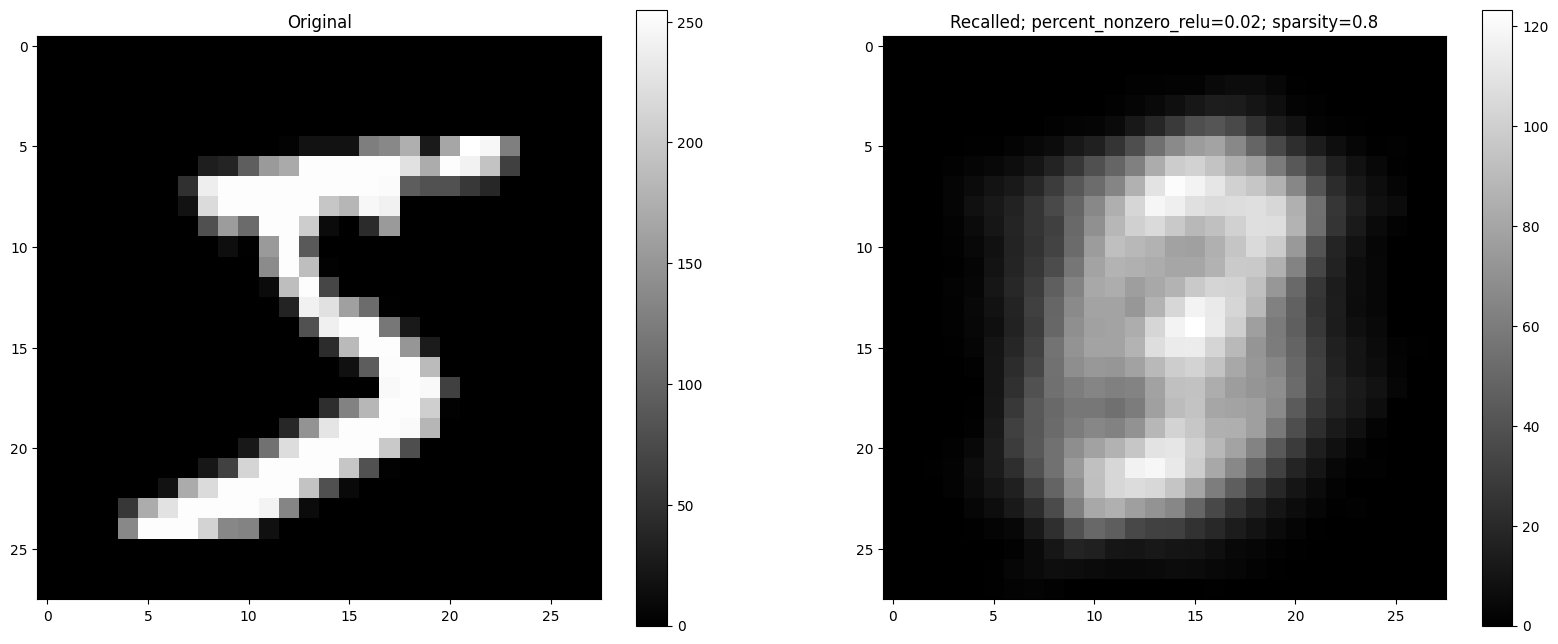

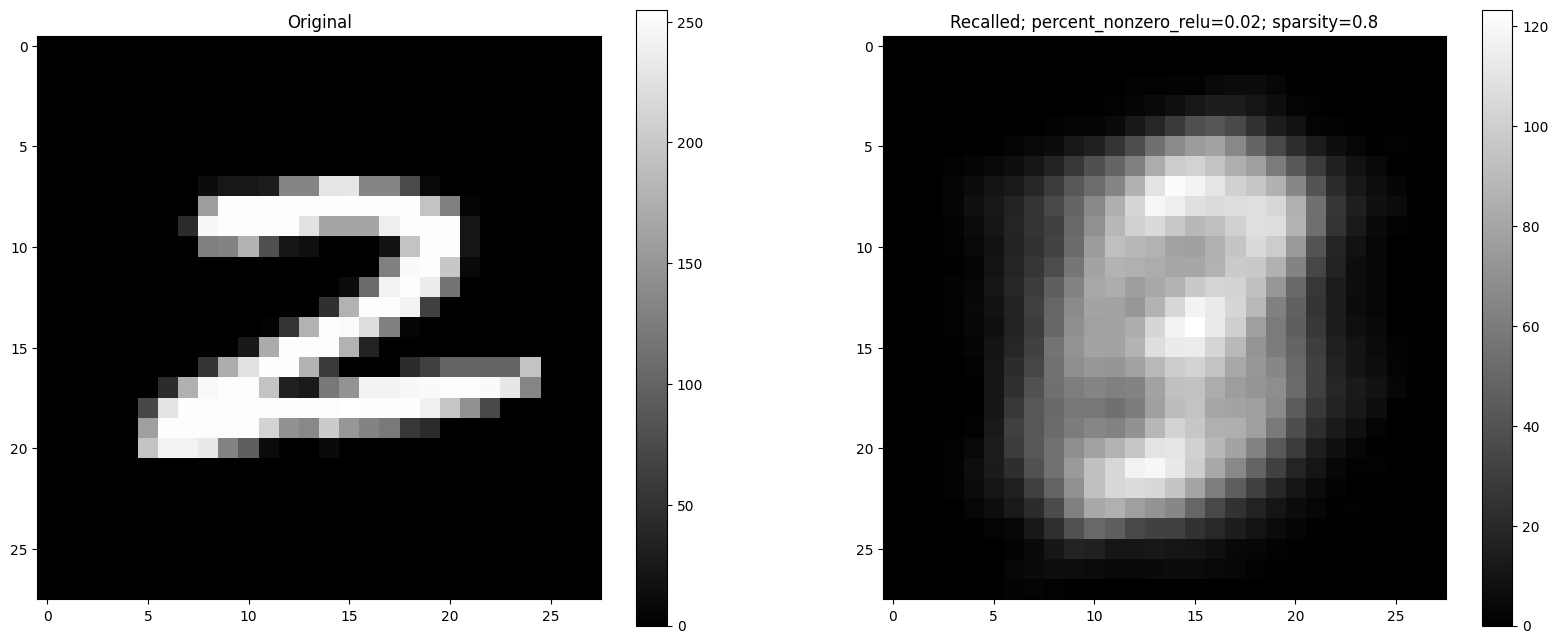

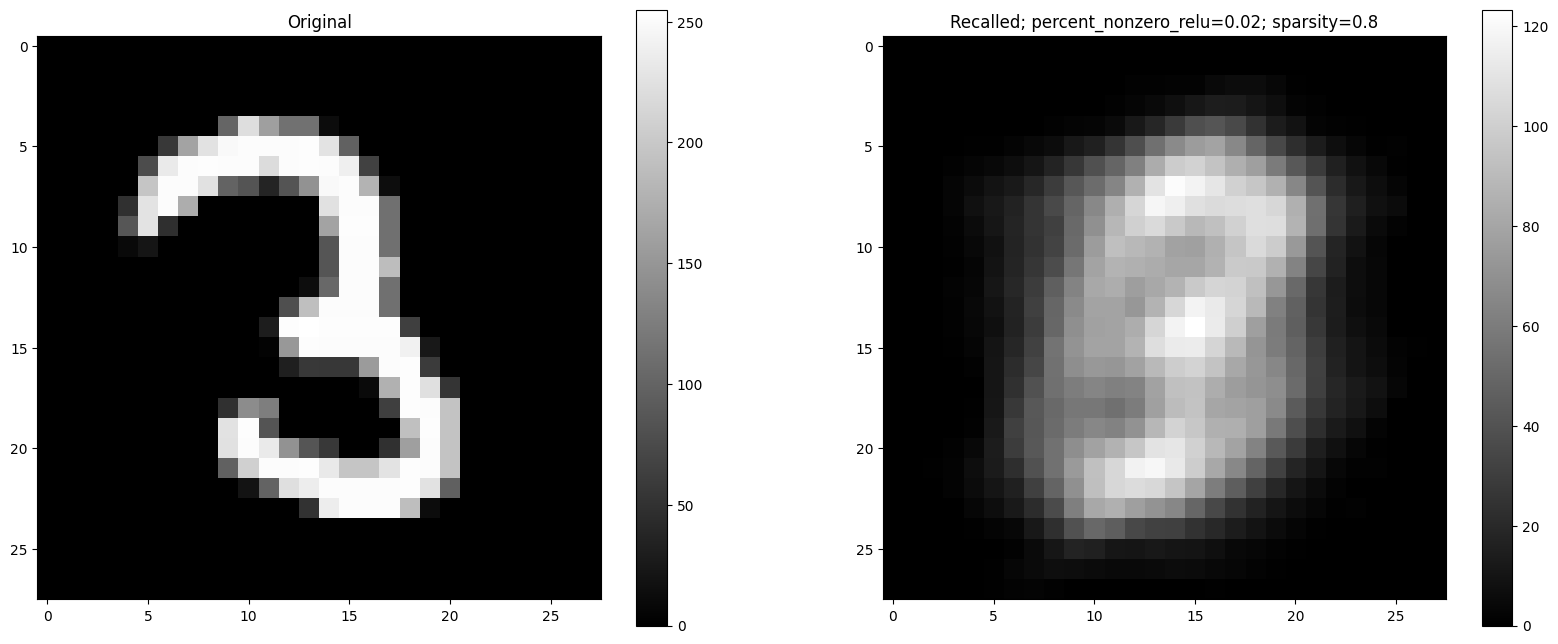

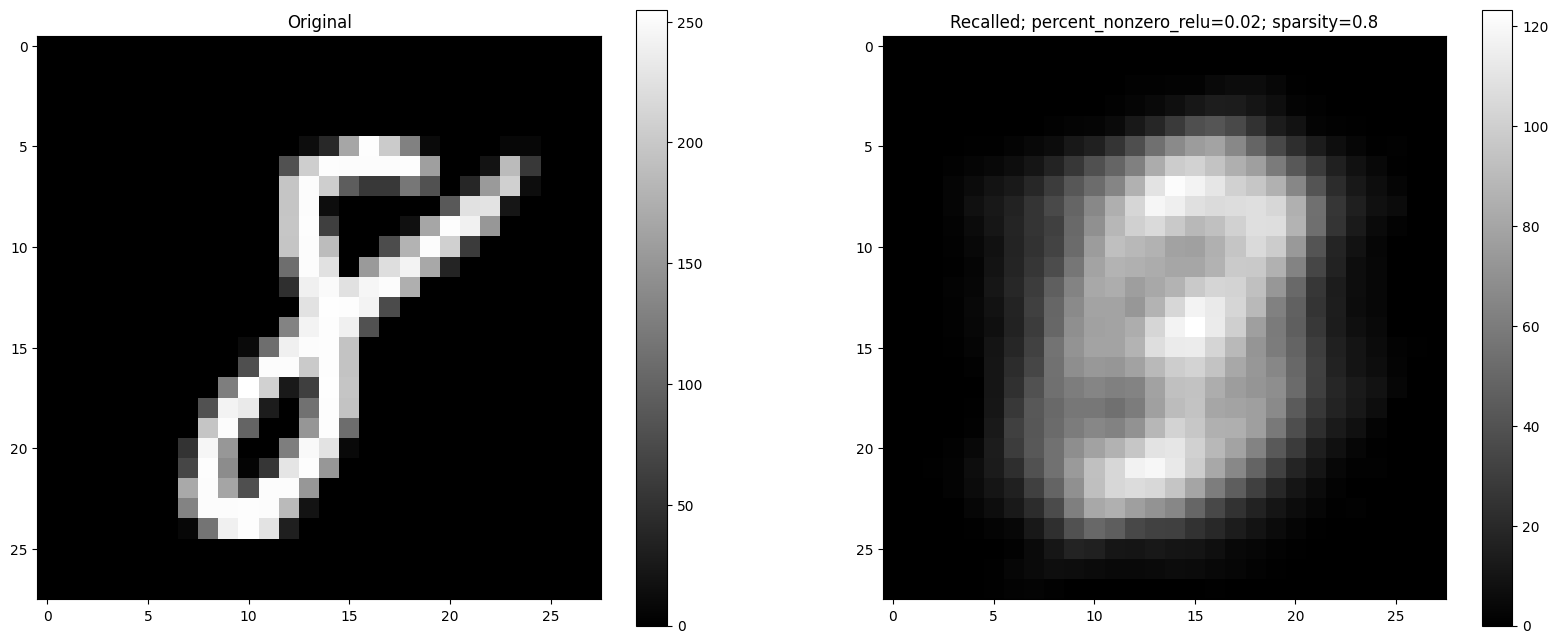

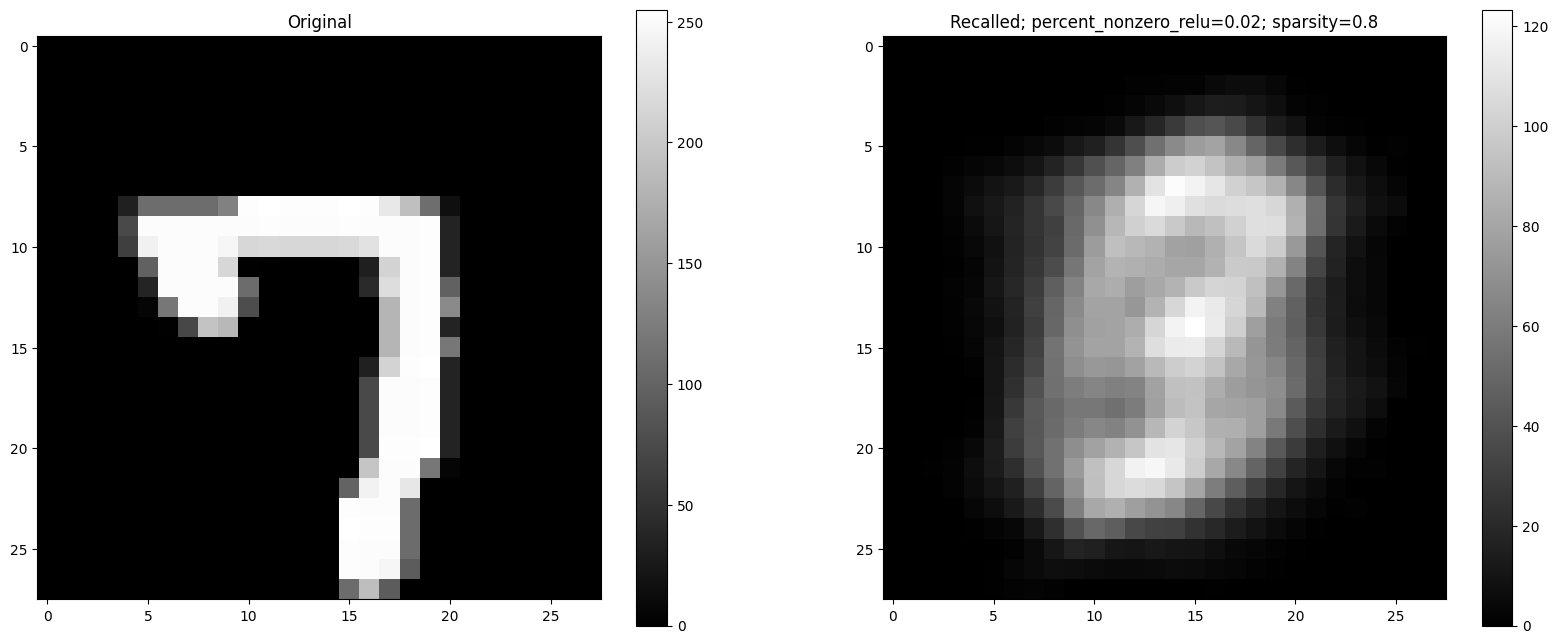

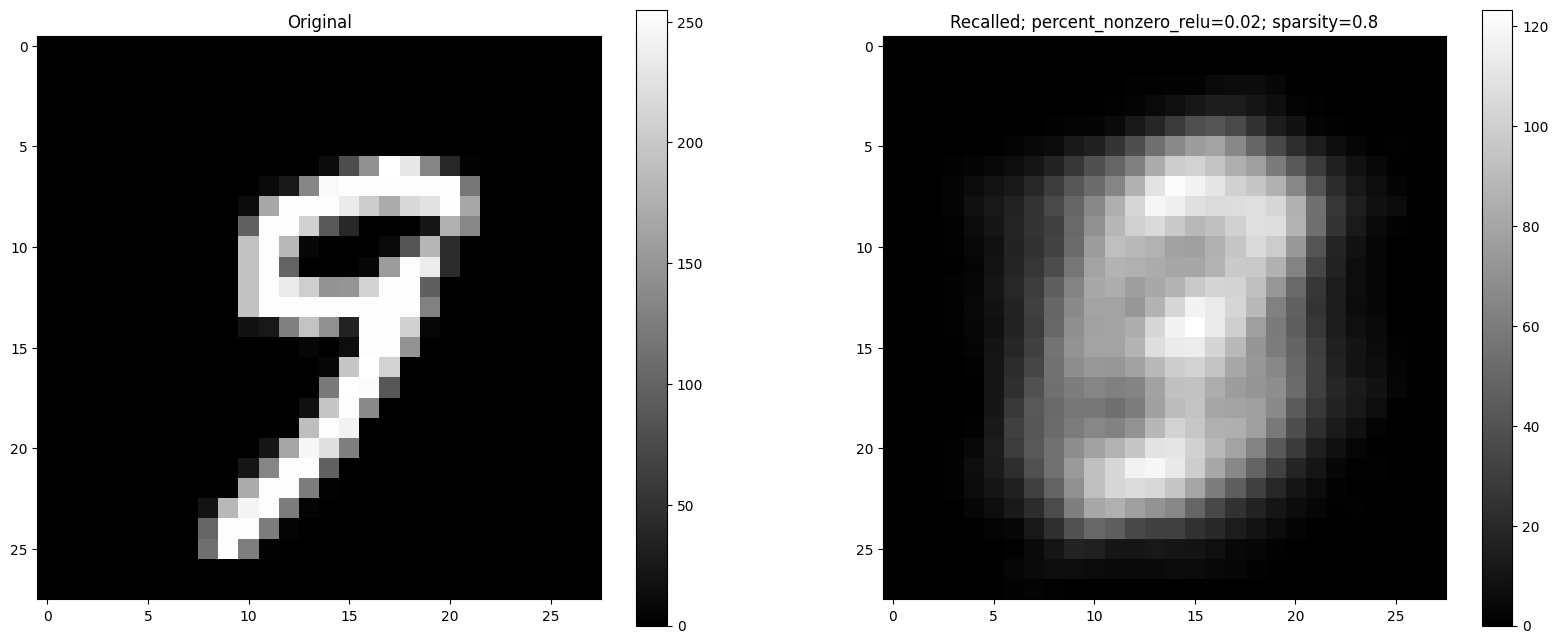

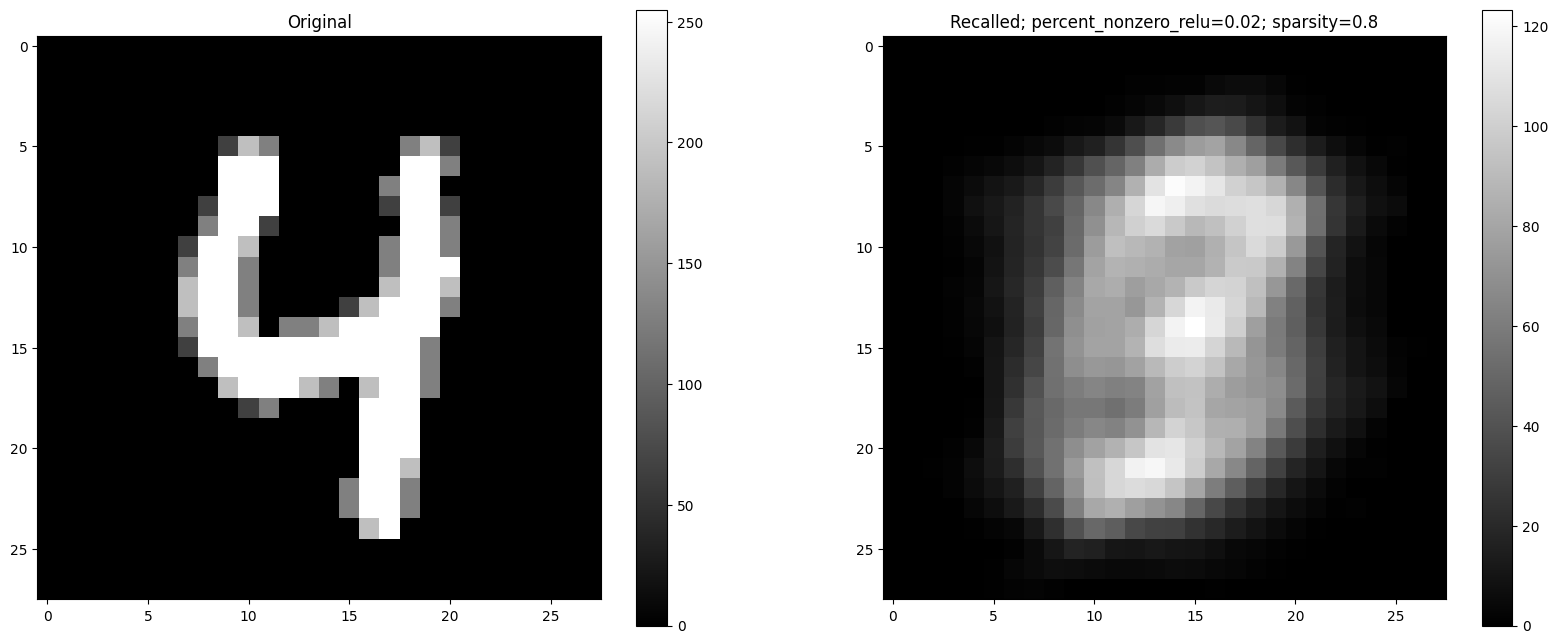

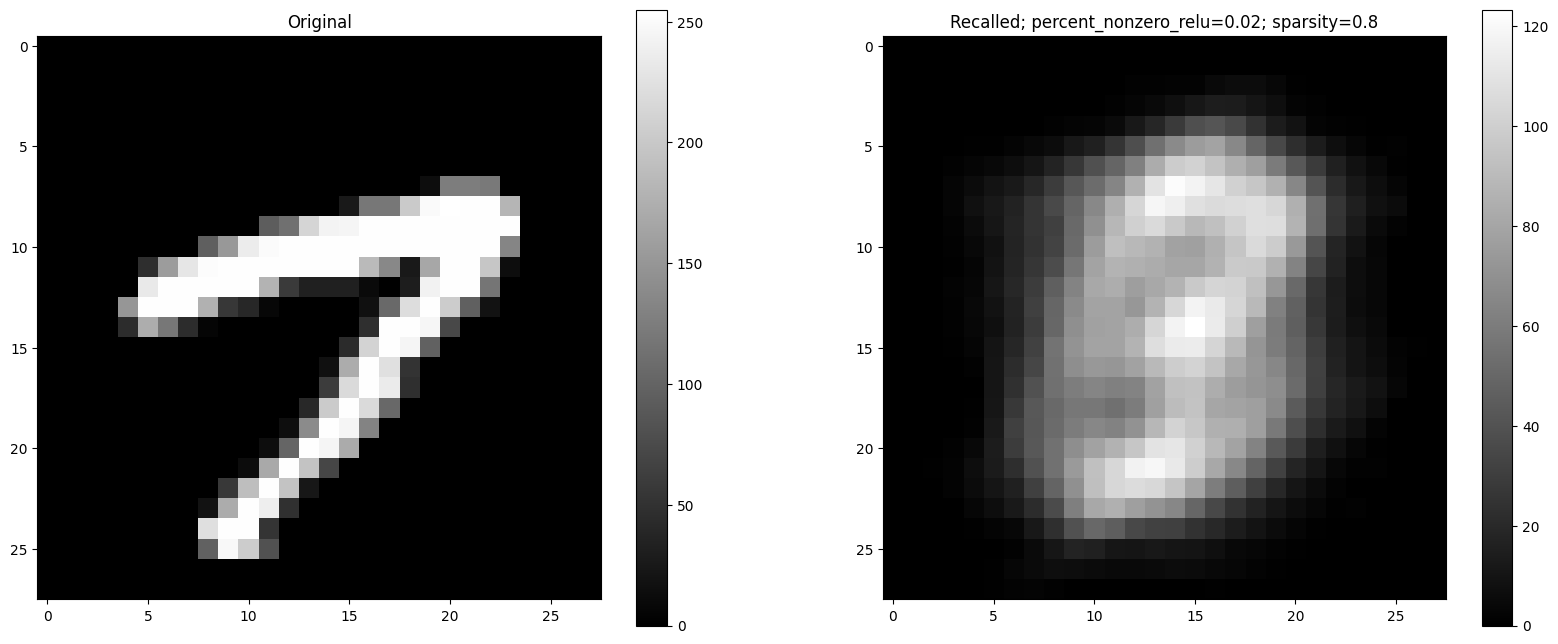

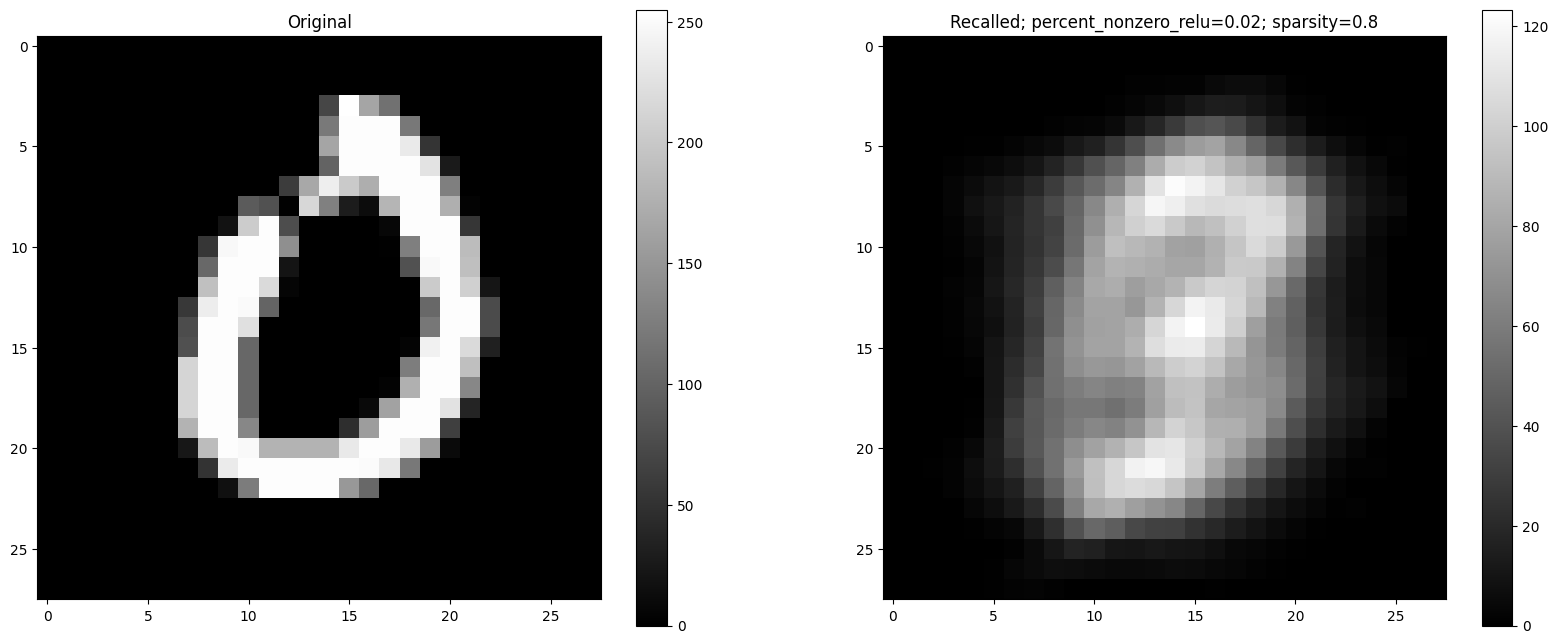

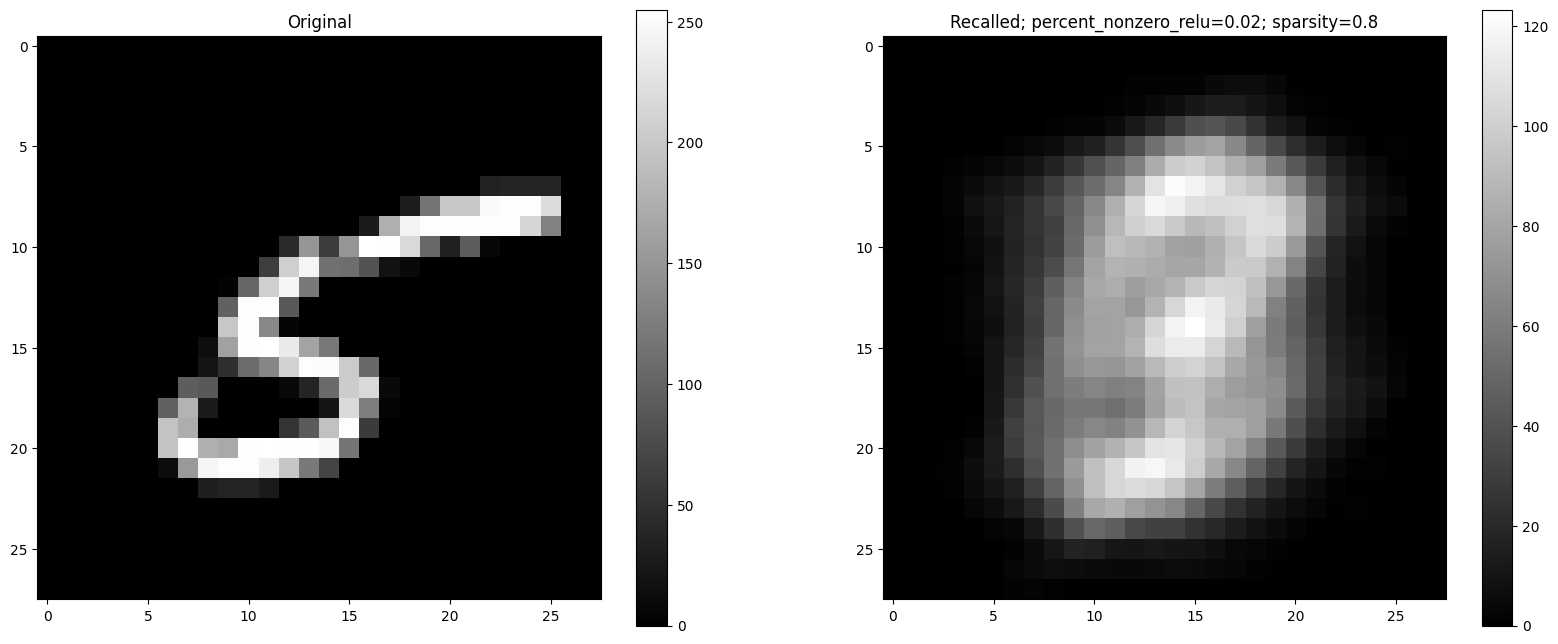

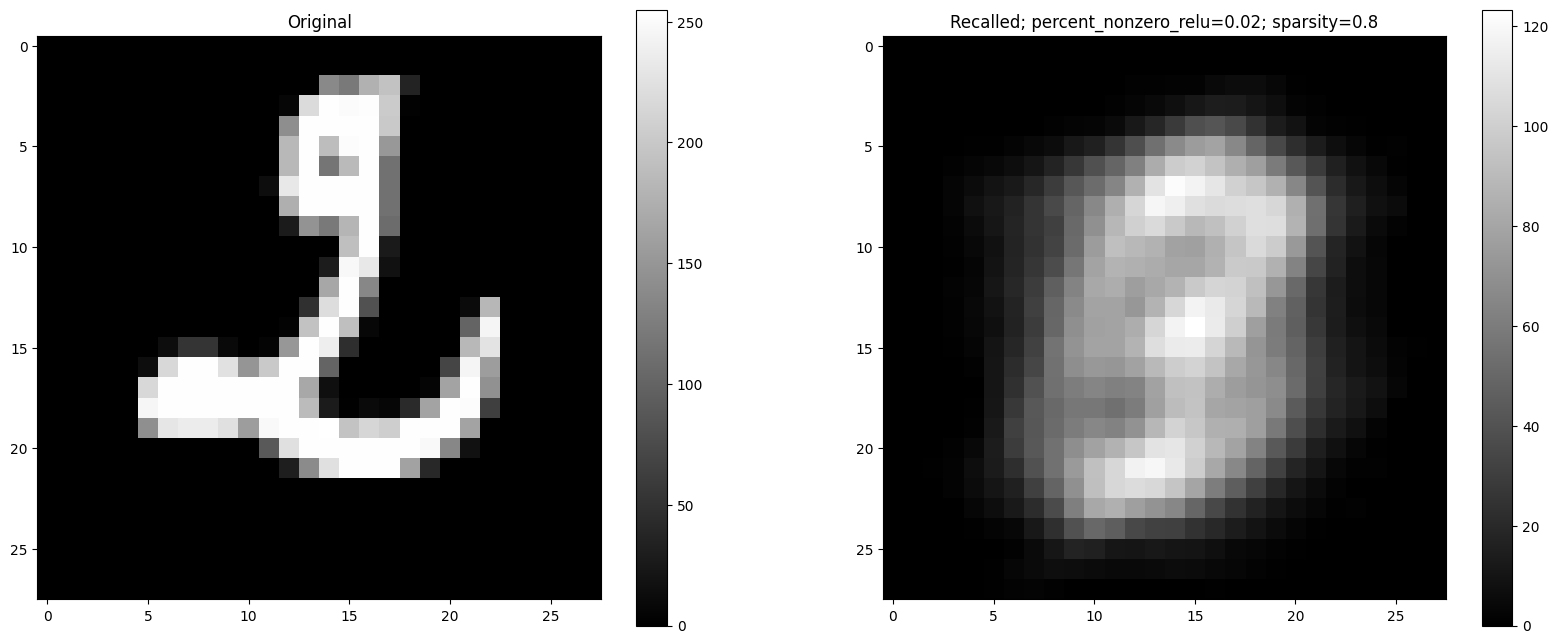

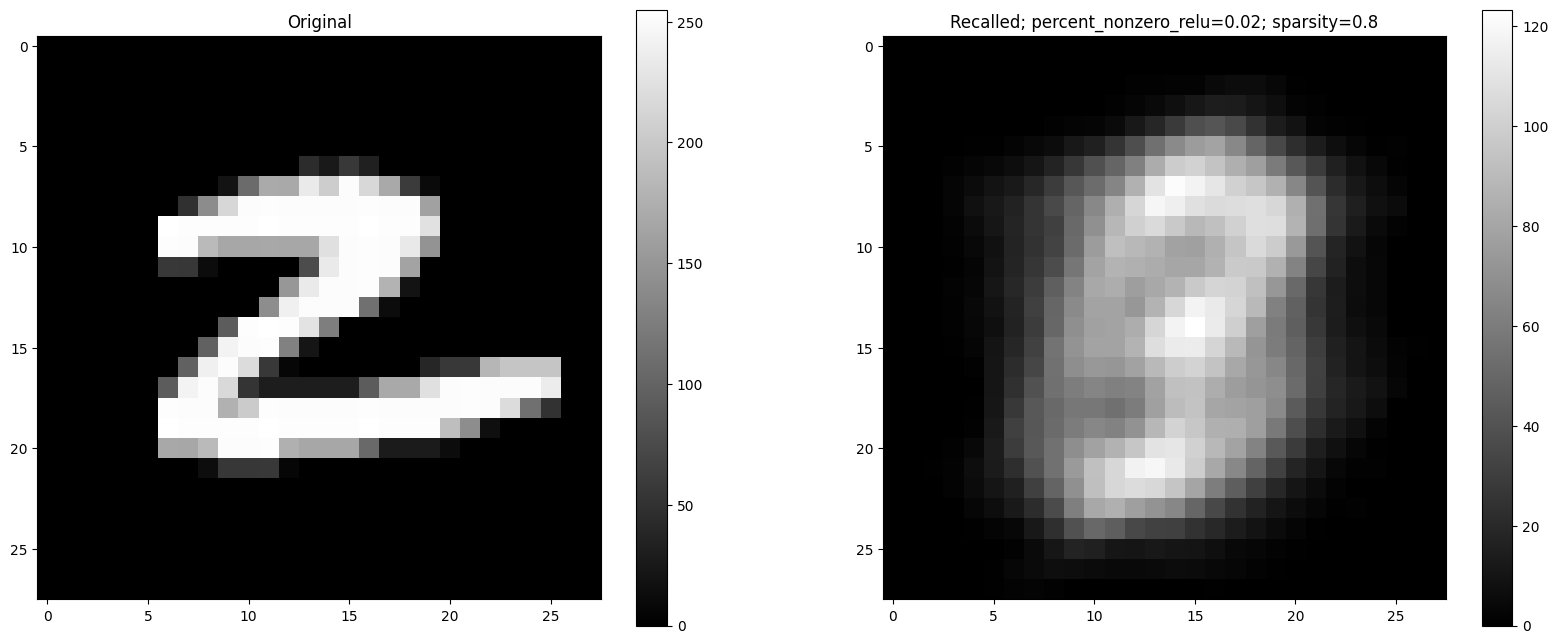

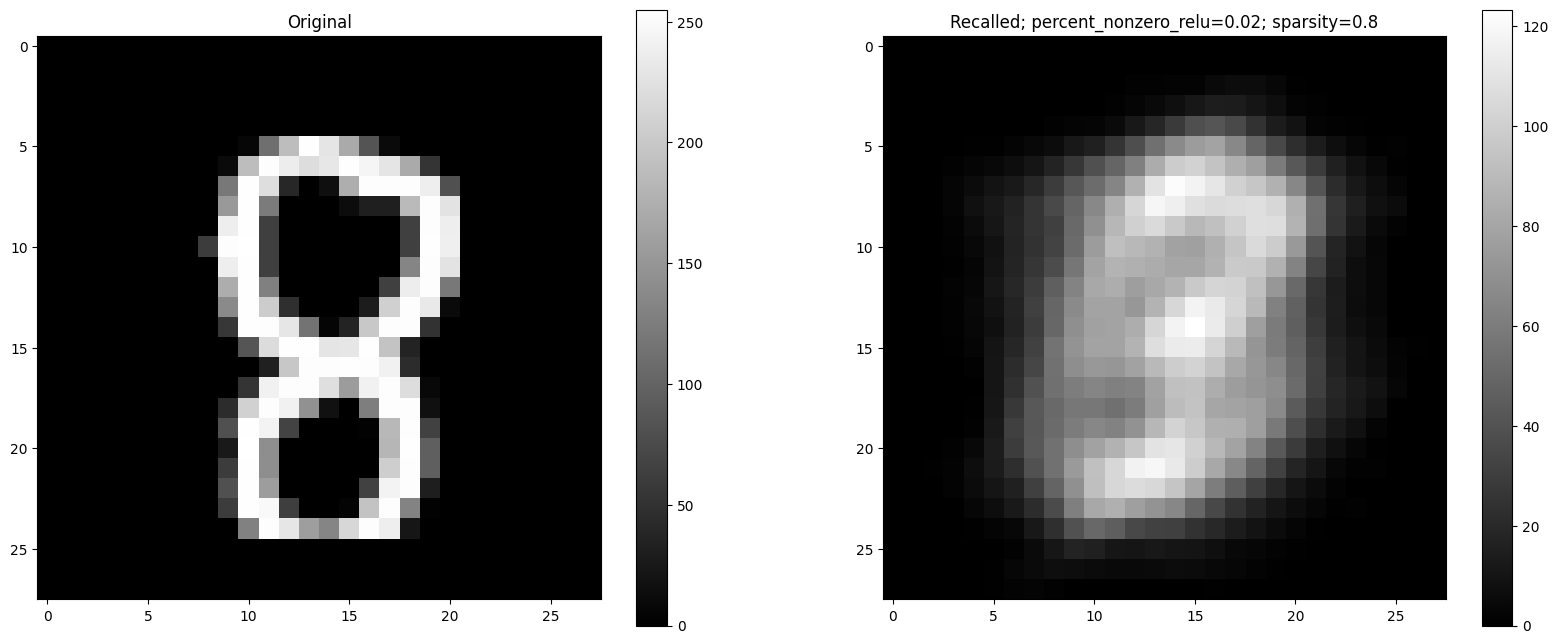

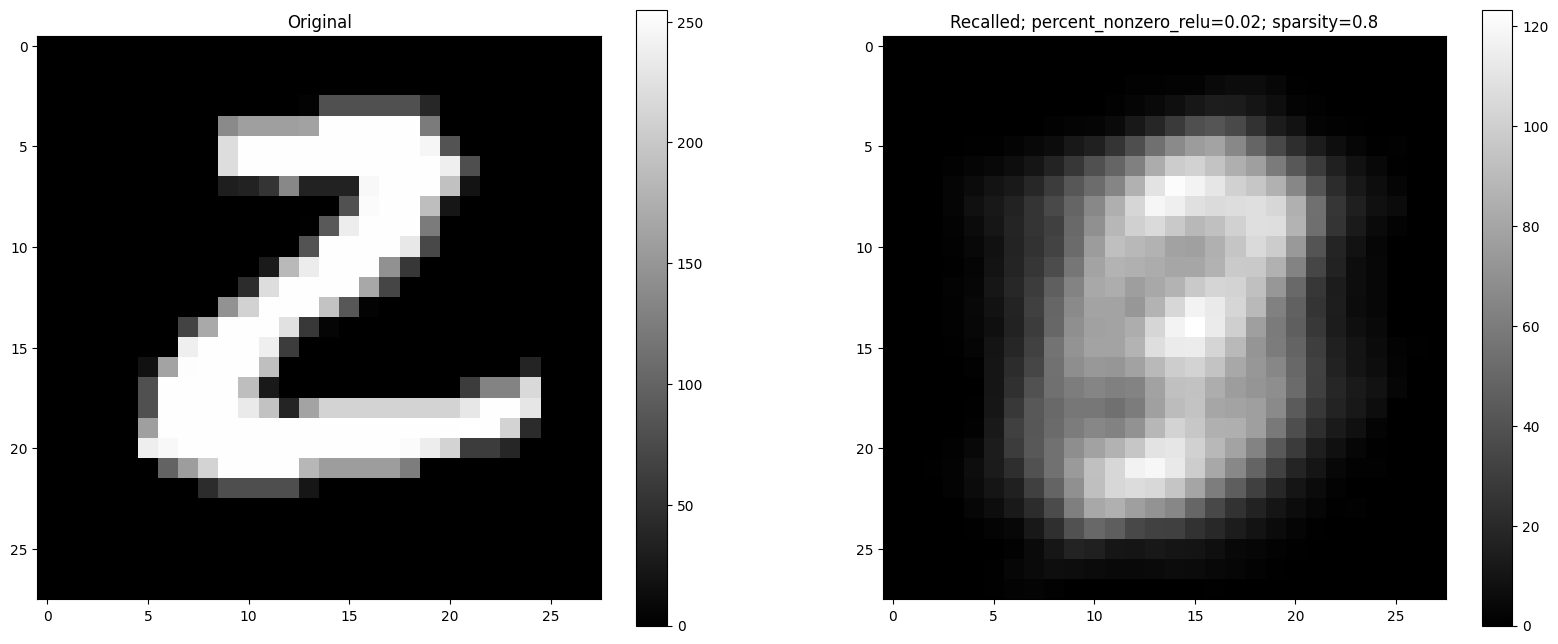

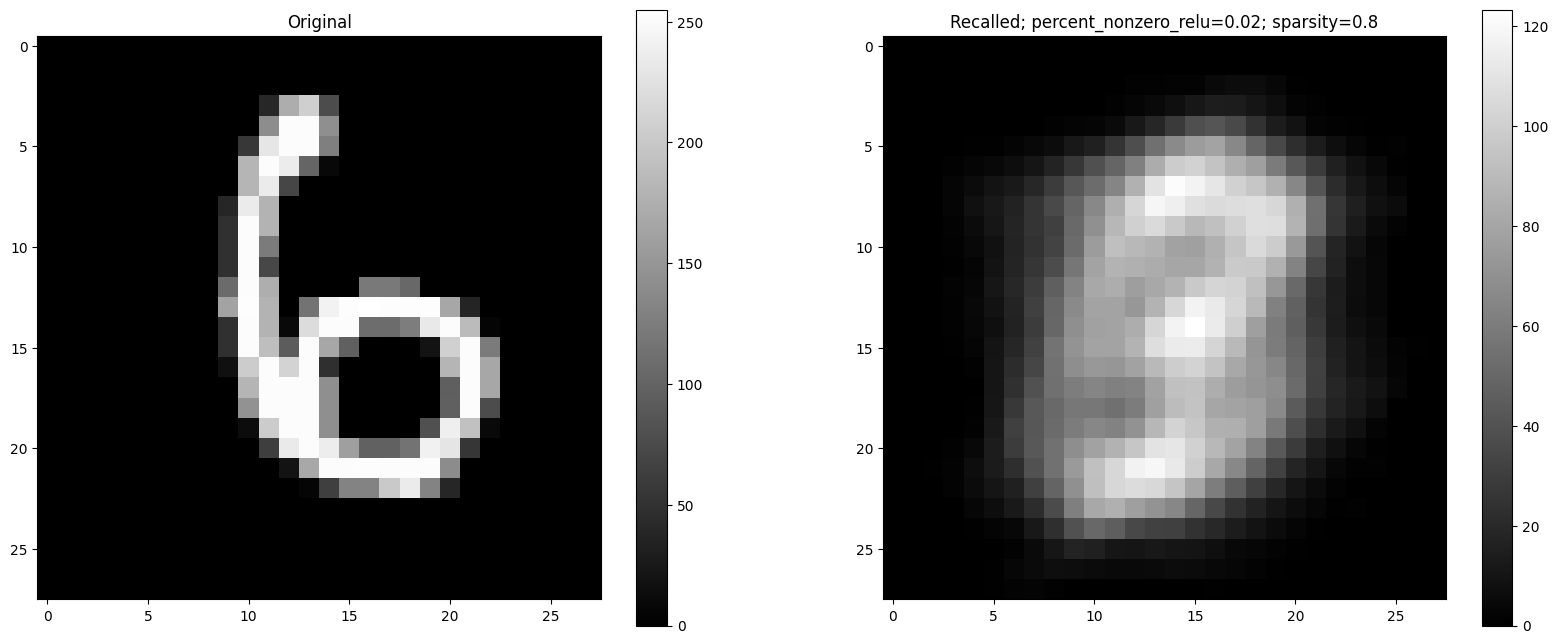

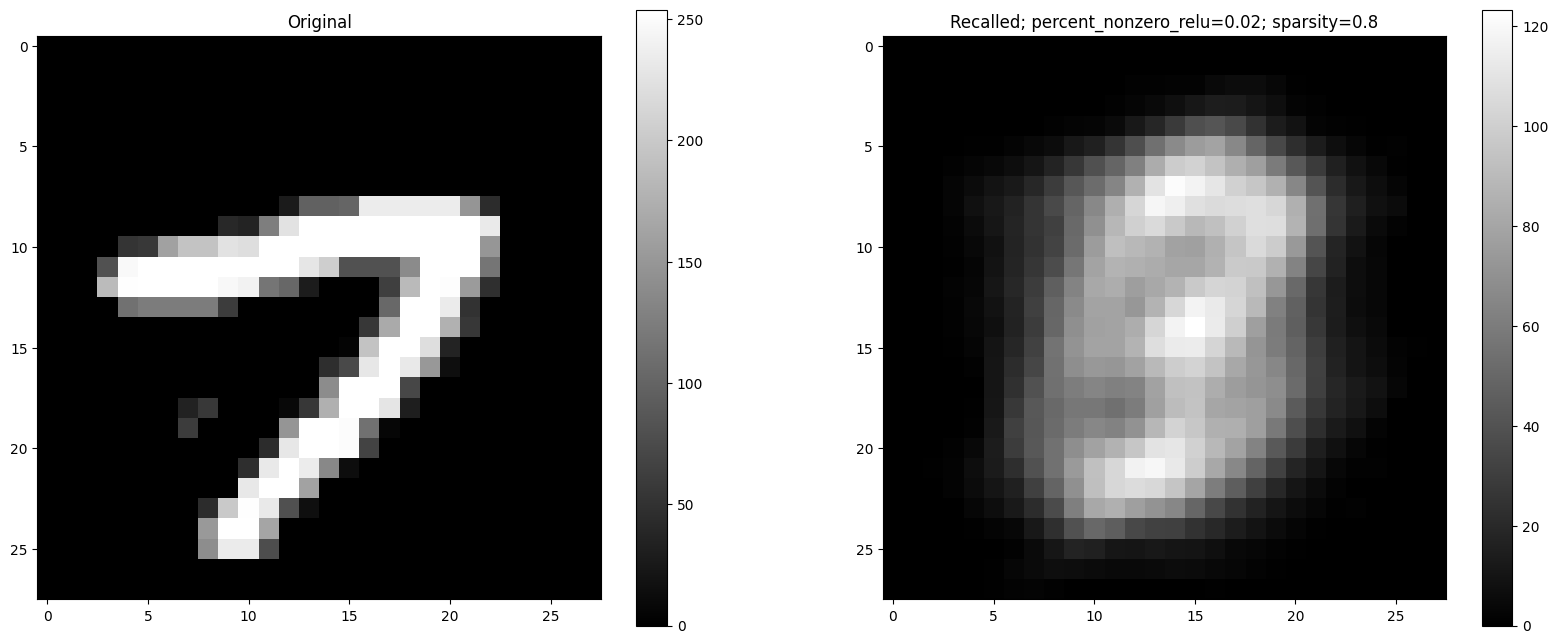

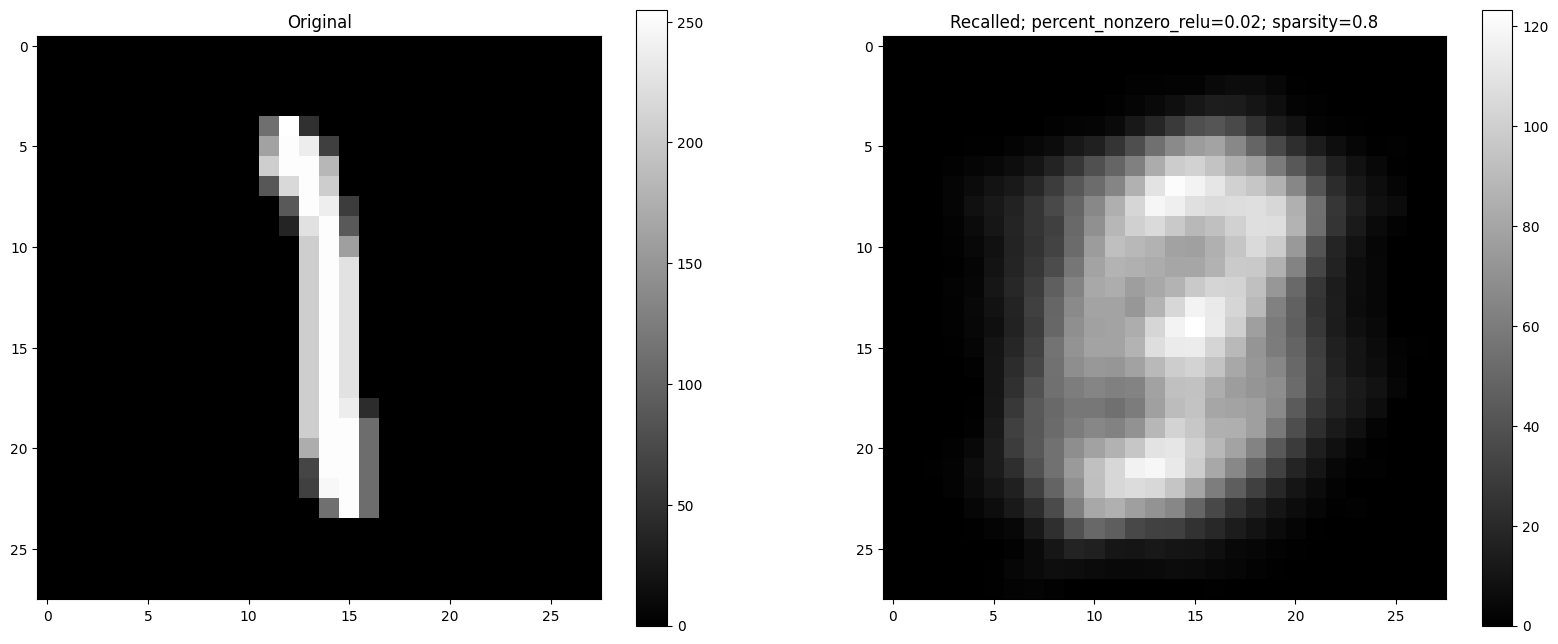

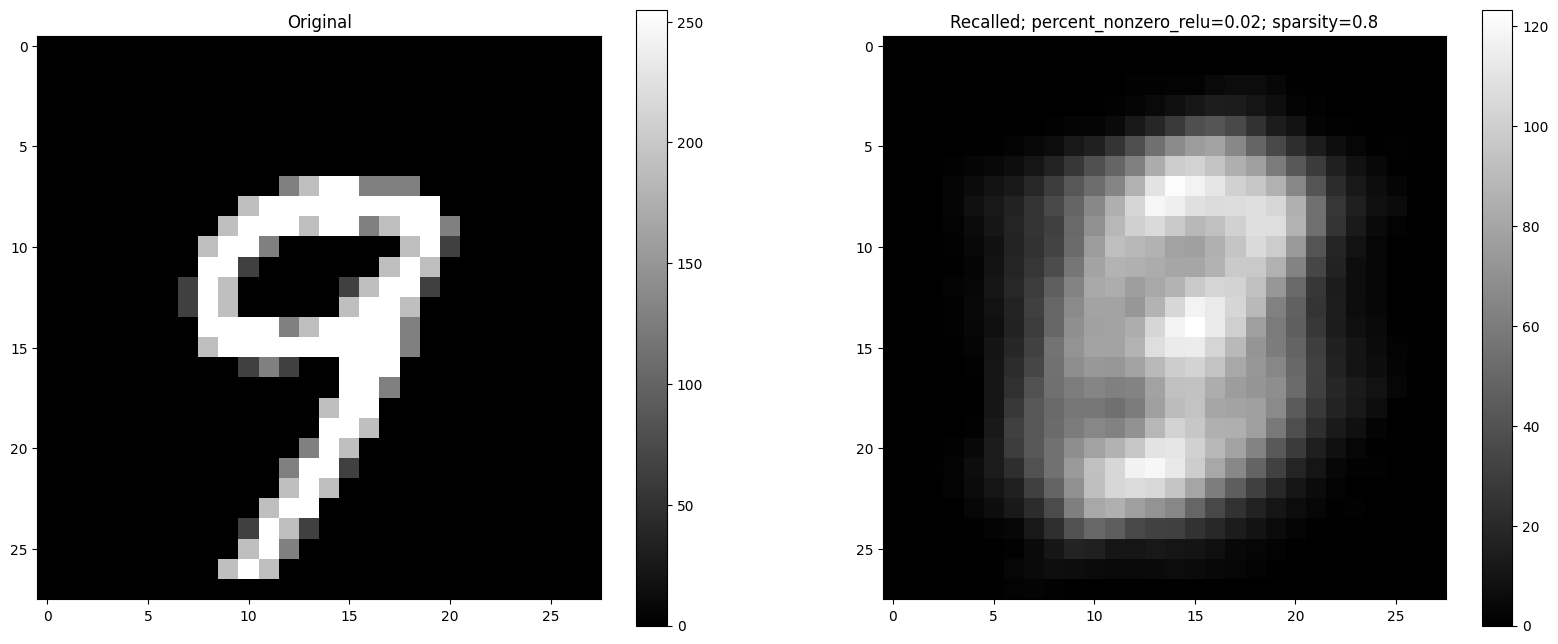

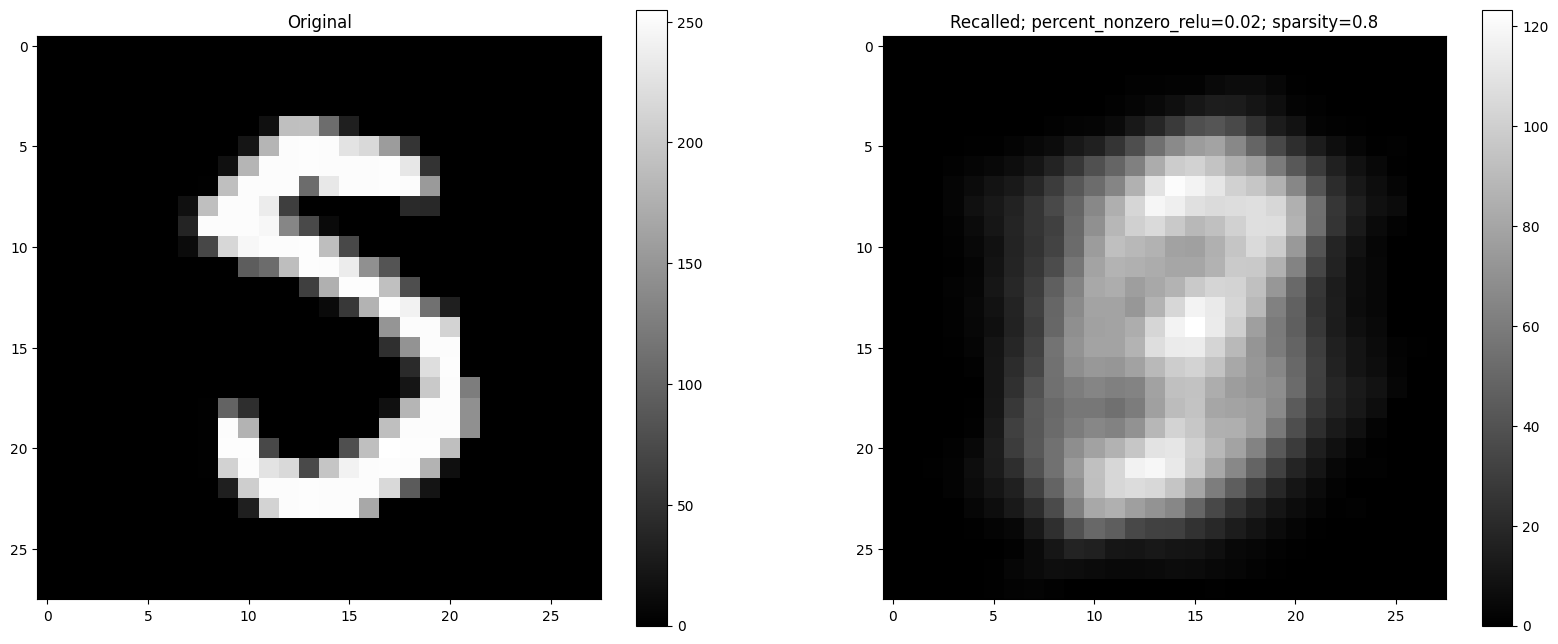

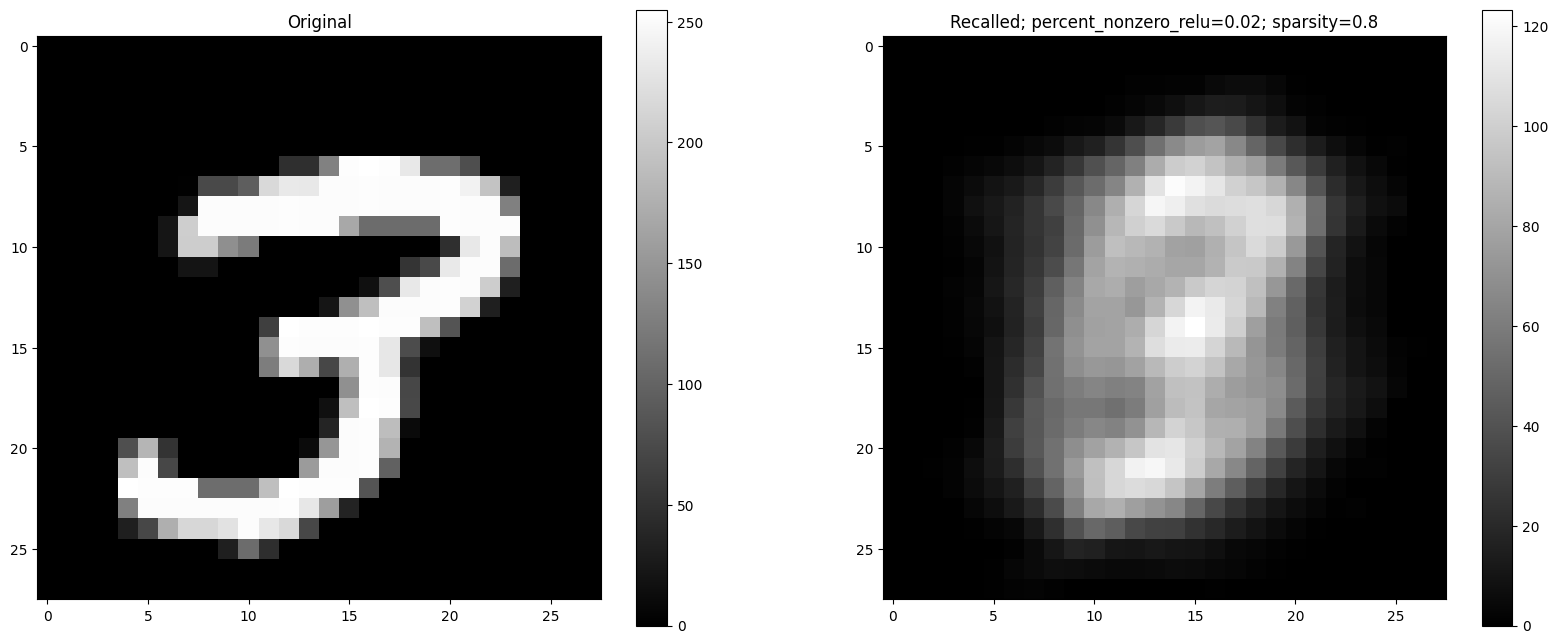

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


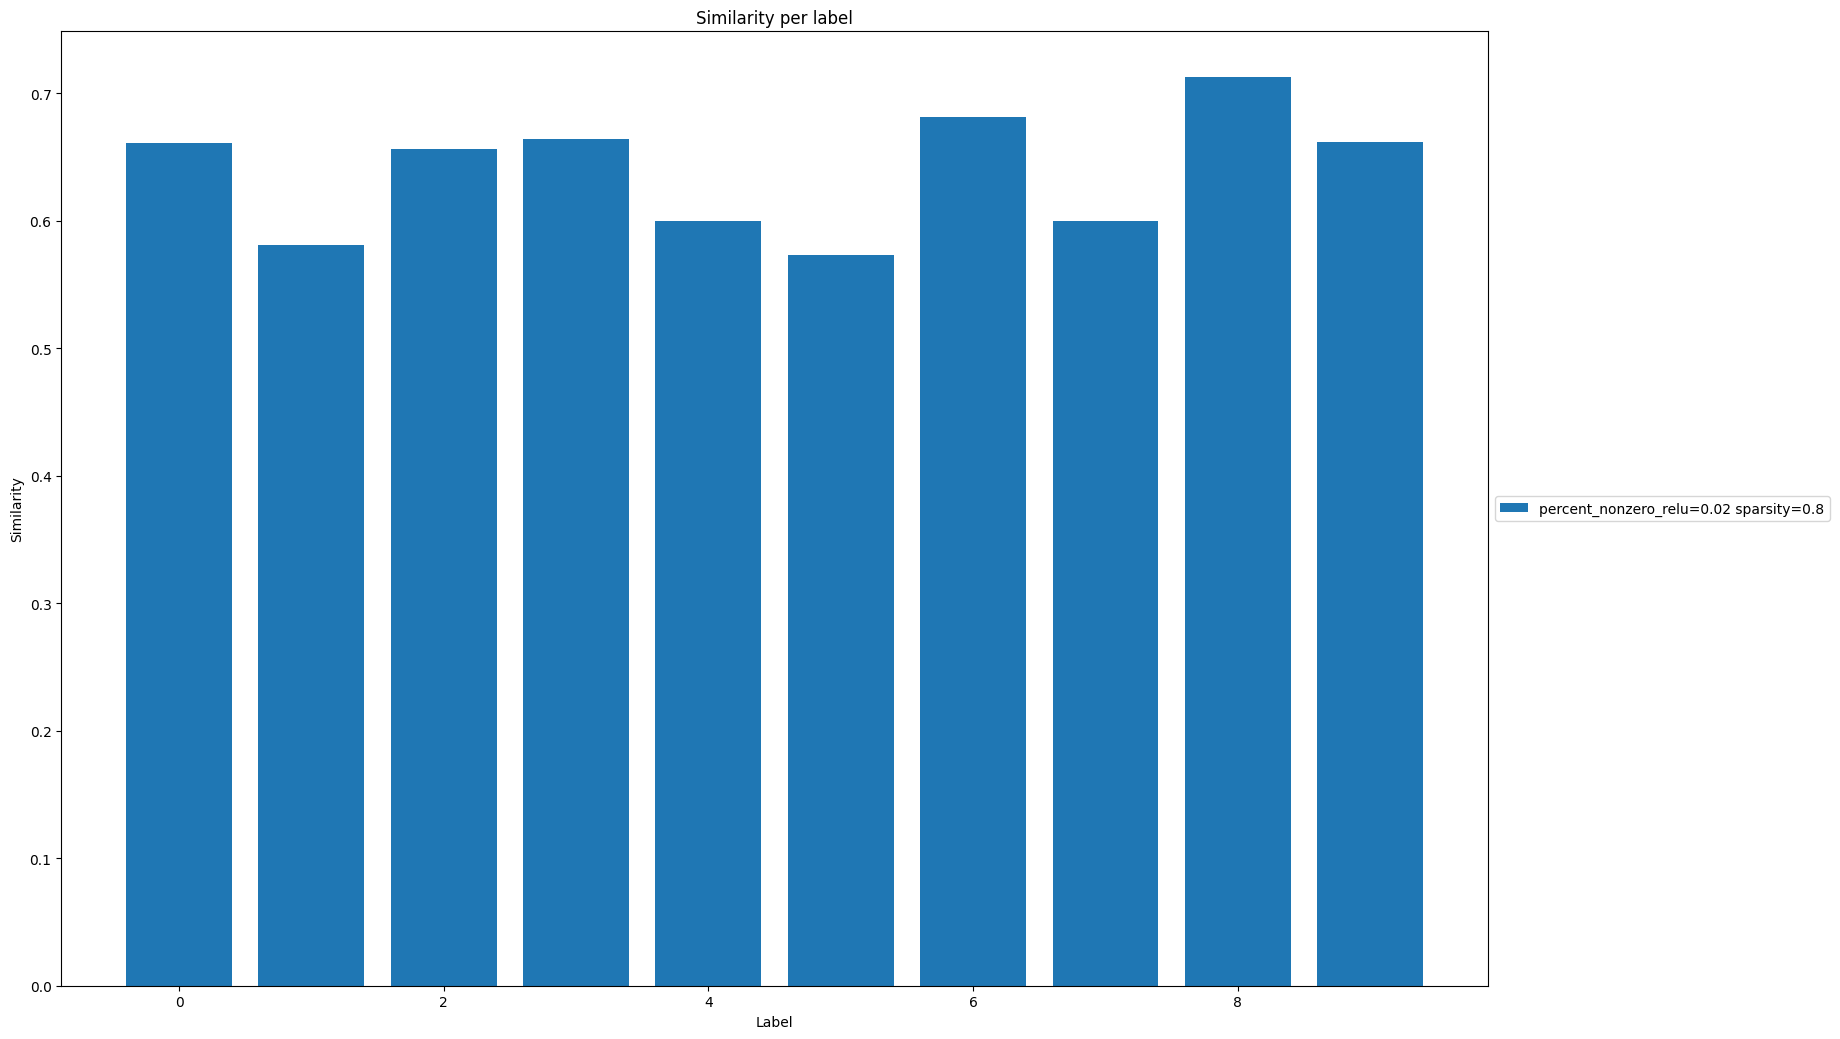

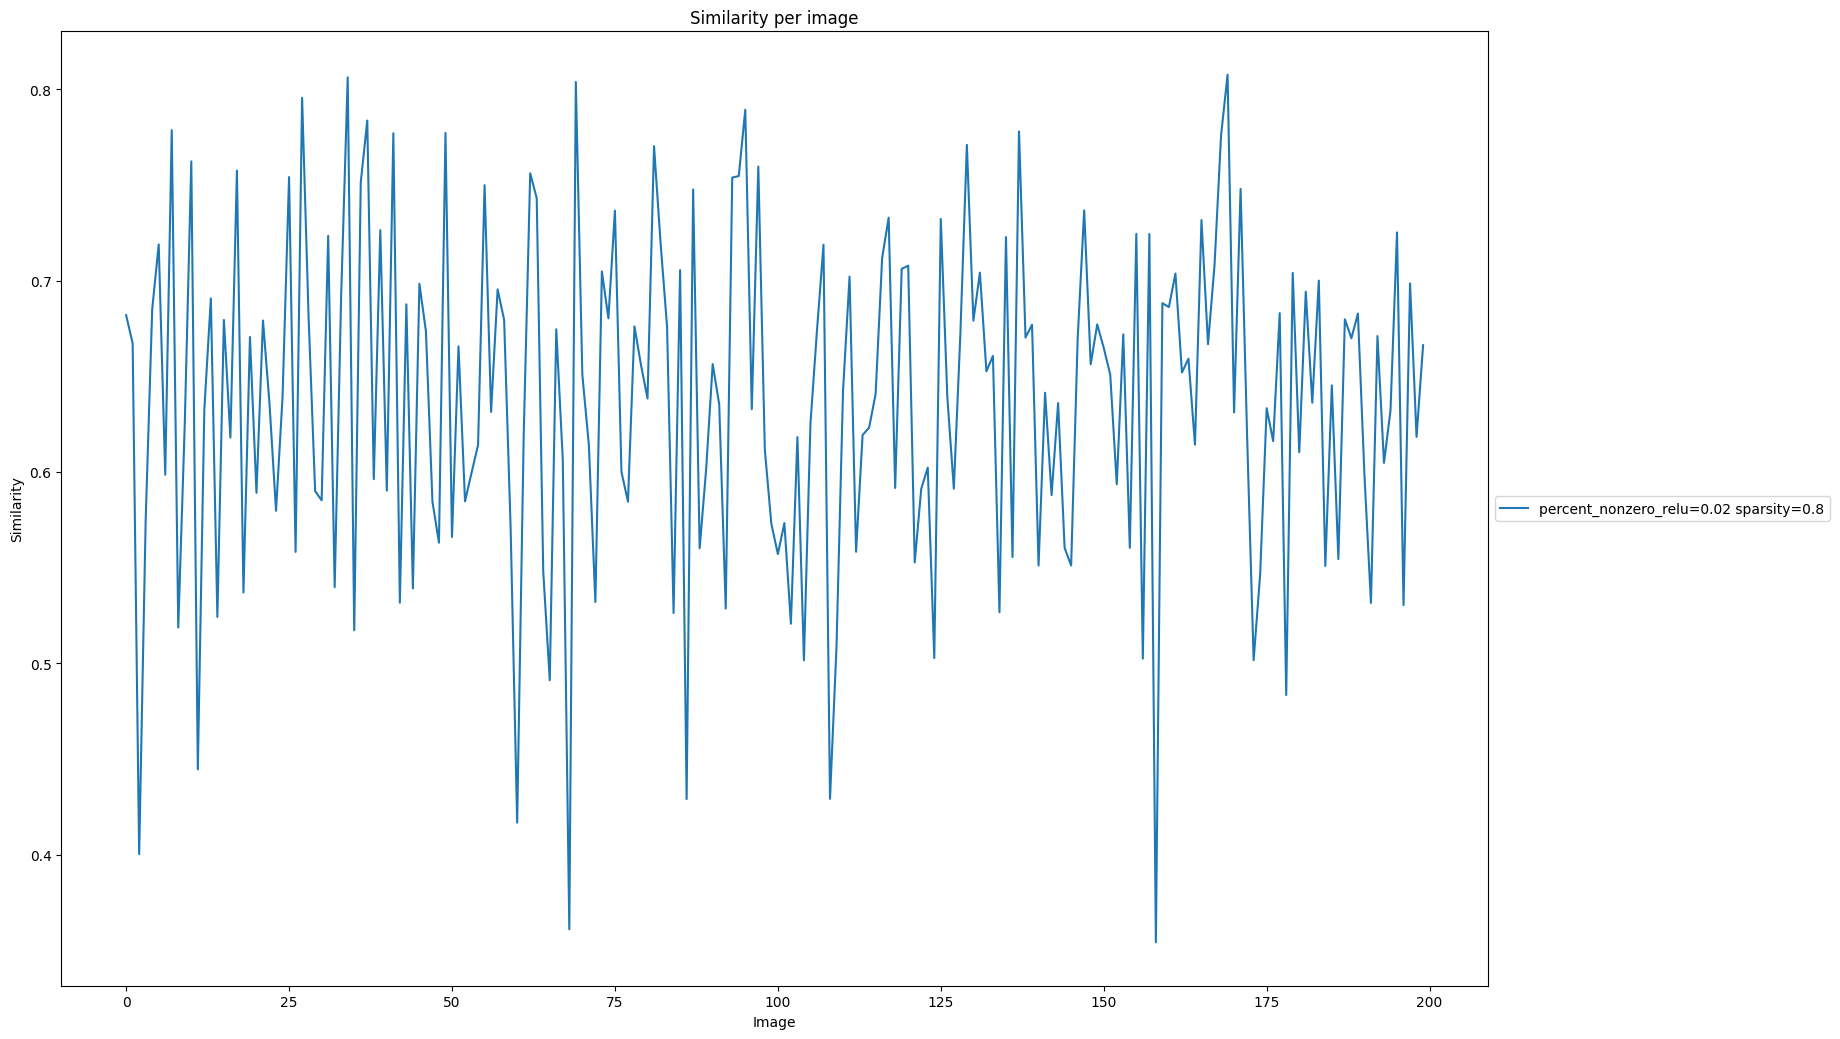

In [2]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = load_mnist_dataset()
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=False,
    noise_level="none",
    use_fix=True,
)
# data, noisy_data = prepare_data_random(noise_scale=0)
v = spacefillingcurve(shapes)

g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(
    observations=data, velocities=v[: len(data)]
)
recalled_imgs = GS.recall(noisy_data)
similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
print(similarity.mean())
for i in range(20):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    im1 = ax[0].imshow(data[(-i)].reshape(28, 28), cmap="gray")
    ax[0].set_title("Original")
    im2 = ax[1].imshow(recalled_imgs[(-i)].reshape(28, 28), cmap="gray")
    title = f"Recalled; percent_nonzero_relu={percent_nonzero_relu}; sparsity={sparse_initialization}"
    ax[1].set_title(title)

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
labels = dataset.train_labels[:num_imgs]
unique_labels = np.unique(labels)
similarity_per_label = []
for label in unique_labels:
    idx = labels == label
    similarity_per_label.append(similarity[idx].mean())
# make bars not overlap
label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.bar(unique_labels, similarity_per_label, label=label)
ax.set_title("Similarity per label")
ax.set_xlabel("Label")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)

label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.plot(similarity, label=label)
ax.set_title("Similarity per image")
ax.set_xlabel("Image")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

tensor(32.3349)


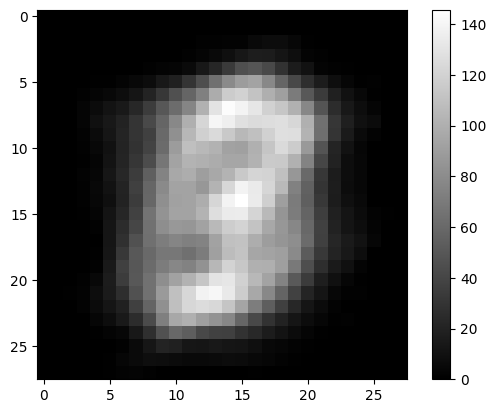

In [3]:
plt.imshow(data.mean(dim=0).reshape(28, 28), cmap="gray")
plt.colorbar()
print(data.mean())

In [4]:
from vectorhash_functions import *

mod_n_positions = []
mod_n_positions_2 = []
mod_n_states = []
mod_n_states_2 = []

# assume shapes are squares

for _ in lambdas:
    mod_n_positions.append(list())
    mod_n_positions_2.append(list())
    mod_n_states.append(list())
    mod_n_states_2.append(list())

for g in g_positions:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_positions2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points_2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

200
199
200
199


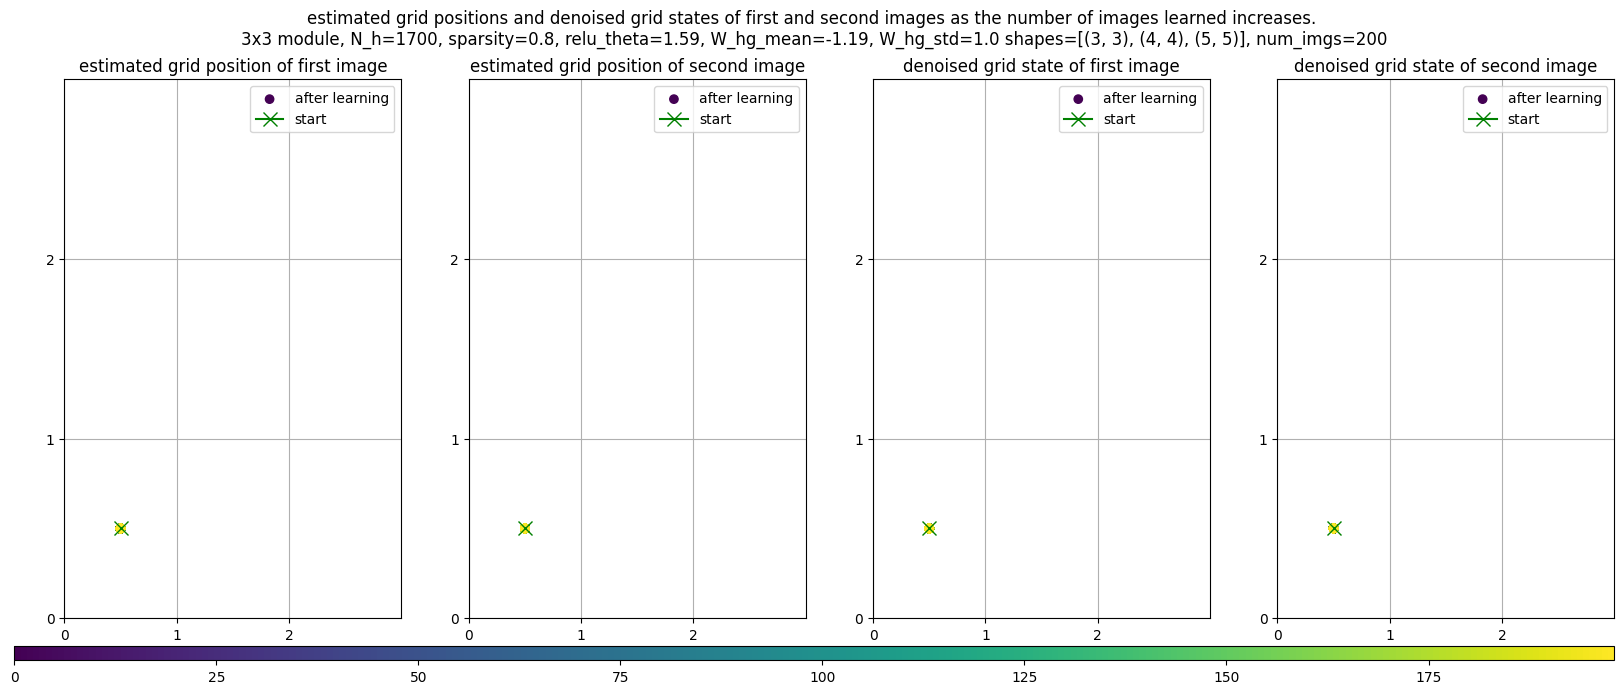

200
199
200
199


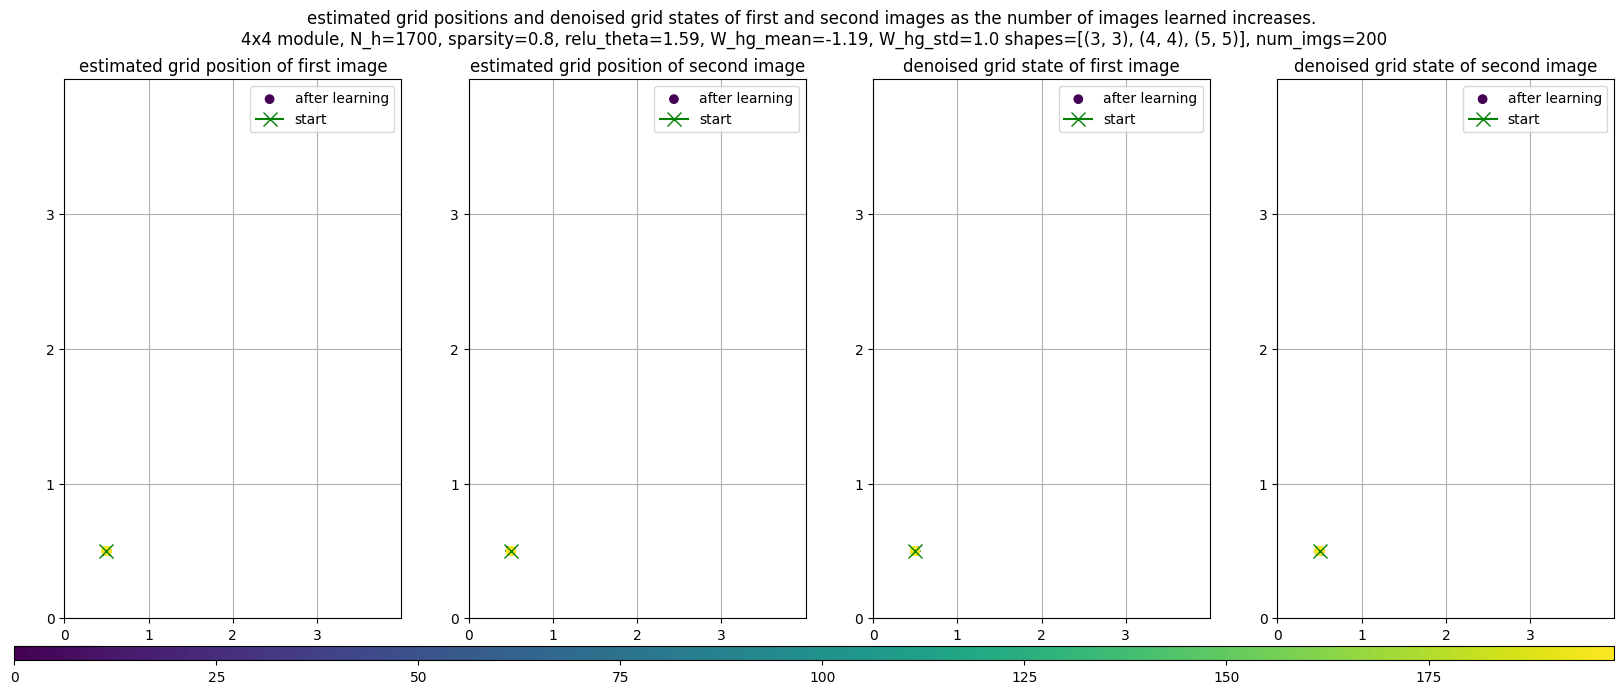

200
199
200
199


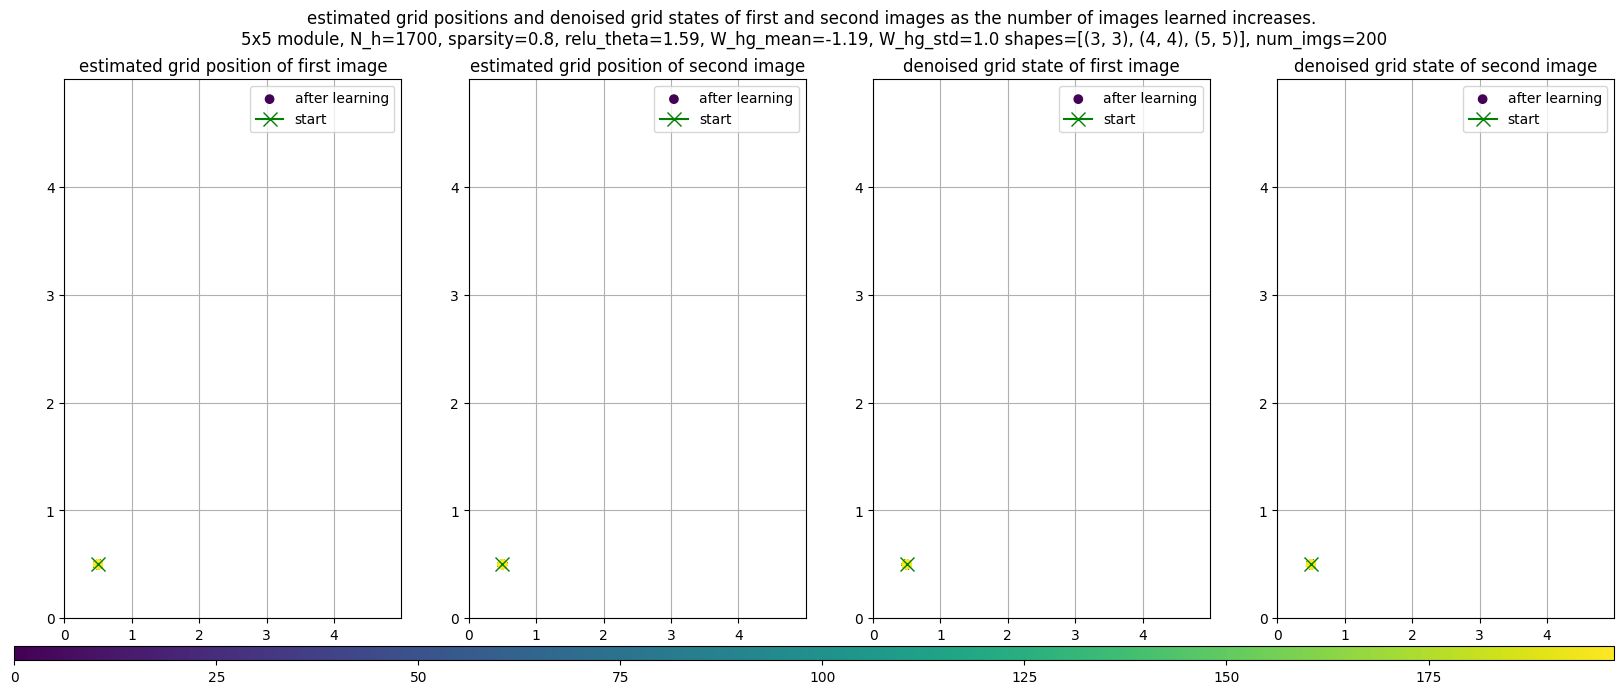

In [5]:
for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l), (l, l), (l, l)],
        points_lists=[
            mod_n_positions[i],
            mod_n_positions_2[i],
            mod_n_states[i],
            mod_n_states_2[i],
        ],
        first_points=[
            mod_n_positions[i][0],
            mod_n_positions_2[i][0],
            mod_n_states[i][0],
            mod_n_states_2[i][0],
        ],
        titles=[
            f"estimated grid position of first image",
            f"estimated grid position of second image",
            f"denoised grid state of first image",
            f"denoised grid state of second image",
        ],
        main_title=f"estimated grid positions and denoised grid states of first and second images as the number of images learned increases. \n{l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta, 2)}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std} shapes={shapes}, num_imgs={num_imgs}",
    )

In [6]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = load_mnist_dataset()
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=True,
    noise_level="none",
    use_fix=True,
)
# data, noisy_data = prepare_data_random(noise_scale=0)
params = [
    [0.01, 0.8],
    [0.02, 0.8],
    [0.03, 0.8],
]  # (percent_nonzero_relu, sparse_initialization)
sims = []
v = spacefillingcurve(shapes)

lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]
for percent_nonzero_relu, sparse_initialization in params:
    W_gh_var = 1
    T = 0.01
    W_hg_std = math.sqrt(W_gh_var)
    W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
    h_normal_mean = len(lambdas) * W_hg_mean
    h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
    relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
        1 - percent_nonzero_relu
    )
    num_imgs = 201

    print(
        percent_nonzero_relu,
        W_hg_mean,
        W_hg_std,
        h_normal_mean,
        h_normal_std,
        relu_theta,
    )

    GS = GridScaffold(
        shapes=shapes,
        N_h=1700,
        input_size=784,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        device=None,
        sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
            sparsity=sparse_initialization, device="cpu"
        ),
        relu_theta=relu_theta,  ######
        from_checkpoint=False,
        T=T,
        ratshift=False,
        pseudo_inverse=False,
        batch_update=False,
        use_h_fix=False,
        learned_pseudo=True,
        epsilon=0.01,
        calculate_update_scaling_method="norm",
        MagicMath=False,
        sanity_check=False,
        calculate_g_method="fast",
        scaling_updates=False,
        dream_fix=None,
        ZeroTol=1,
    )

    g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(
        observations=data, velocities=v[: len(data)]
    )
    recalled_imgs = GS.recall(noisy_data)
    similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
    sims.append(similarity)
    print(similarity.mean())
    for i in range(20):
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        im1 = ax[0].imshow(data[(-i)].reshape(28, 28), cmap="gray")
        ax[0].set_title("Original")
        im2 = ax[1].imshow(recalled_imgs[(-i)].reshape(28, 28), cmap="gray")
        title = f"Recalled; percent_nonzero_relu={percent_nonzero_relu}; sparsity={sparse_initialization}"
        ax[1].set_title(title)

        fig.colorbar(im1, ax=ax[0])
        fig.colorbar(im2, ax=ax[1])
        plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
for i in range(len(sims)):
    similarity = sims[i]
    percent_nonzero_relu, sparse_initialization = params[i]

    labels = dataset.train_labels[:num_imgs]
    unique_labels = np.unique(labels)
    similarity_per_label = []
    for label in unique_labels:
        idx = labels == label
        similarity_per_label.append(similarity[idx].mean())
    # make bars not overlap
    label = (
        f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
    )
    ax.bar(unique_labels, similarity_per_label, label=label)
    ax.set_title("Similarity per label")
    ax.set_xlabel("Label")
    ax.set_ylabel("Similarity")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
for i in range(len(sims)):
    similarity = sims[i]
    percent_nonzero_relu, sparse_initialization = params[i]
    label = (
        f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
    )
    ax.plot(similarity, label=label)
    ax.set_title("Similarity per image")
    ax.set_xlabel("Image")
    ax.set_ylabel("Similarity")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

0.01 -1.3431175713061931 1.0 -4.02935271391858 1.7320508075688772 1.8019813147290409


TypeError: GridScaffold.__init__() got an unexpected keyword argument 'epsilon'

200
200


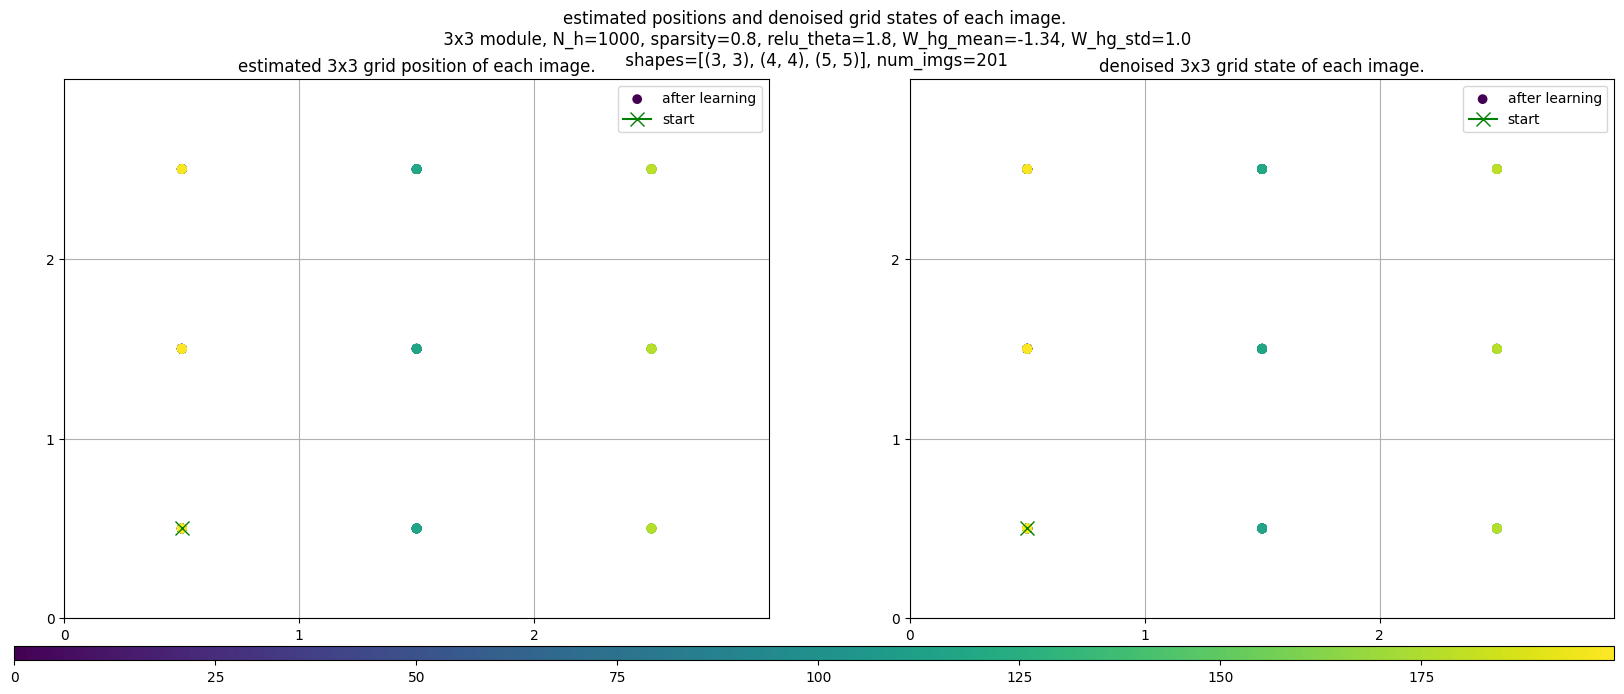

200
200


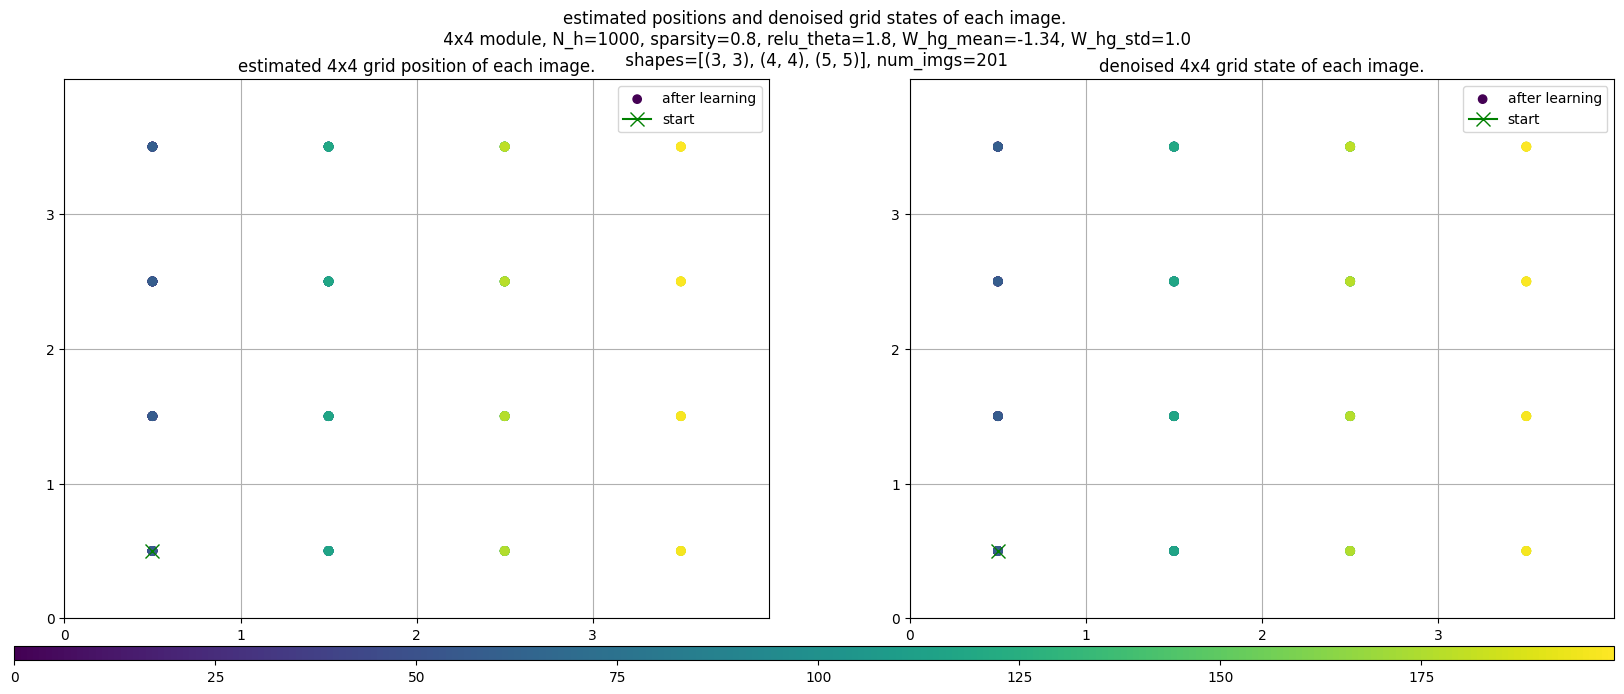

200
200


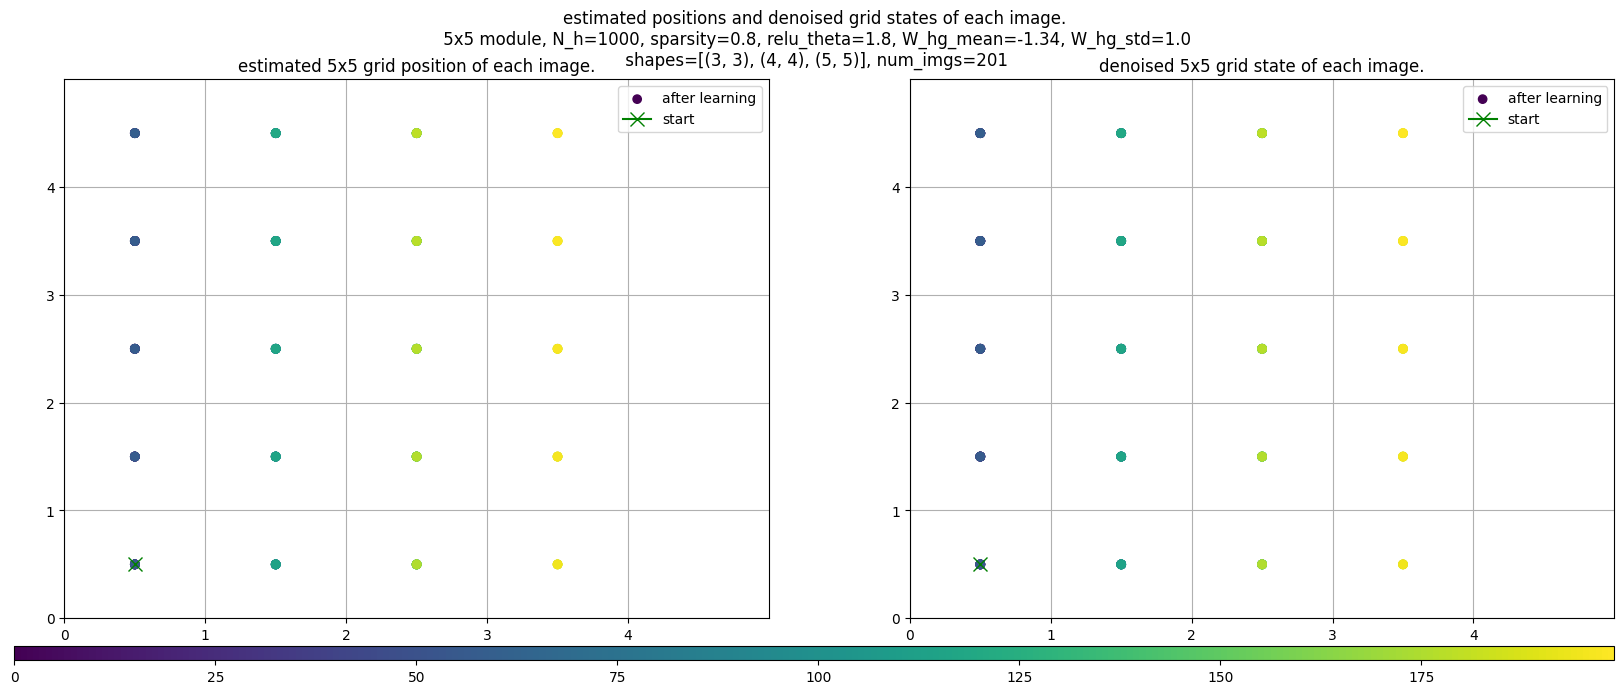

In [ ]:
point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )

Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 418.0
avg nonzero H_denoised: 224.0
tensor(0.4504)
tensor(3.7709e-08)


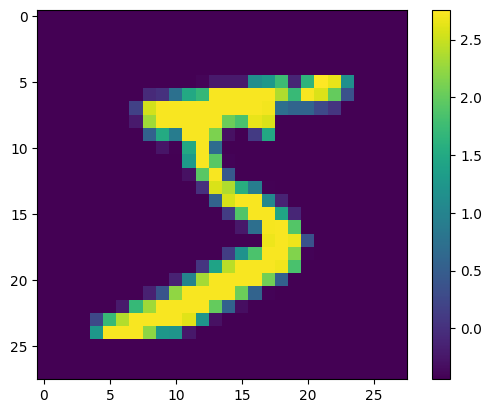

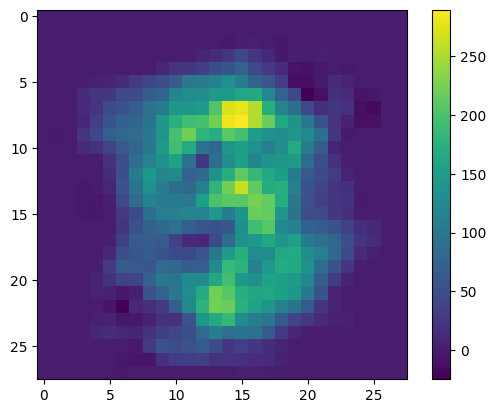

In [ ]:
img = data[0]
recalled = GS.recall(img)
print(torch.cosine_similarity(img, recalled).mean())

plt.imshow(img.reshape(28, 28))
print(img.mean())
plt.colorbar()
plt.show()
plt.imshow((recalled).reshape(28, 28))
plt.colorbar()
plt.show()

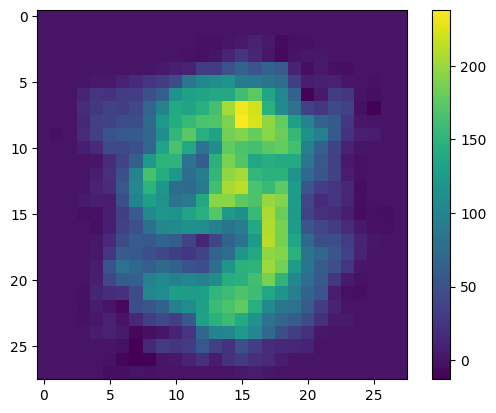

In [ ]:
plt.imshow(
    GS.sensory_from_hippocampal(GS.hippocampal_from_grid(GS.G[3200])).reshape(28, 28)
)
plt.colorbar()
plt.show()

/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_32044/728696423.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_by_class = torch.tensor(data).float().to("cpu")


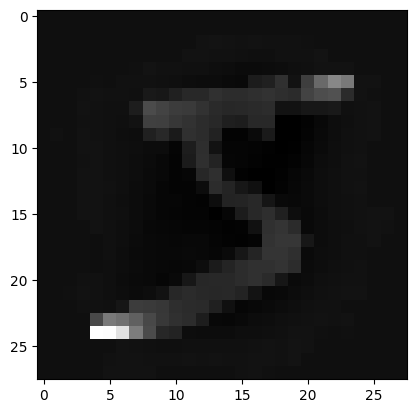

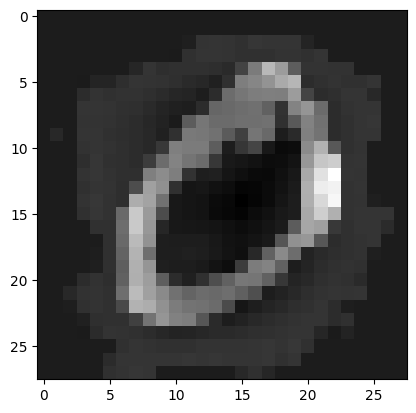

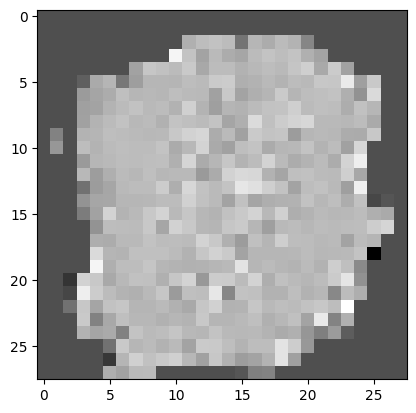

200
200


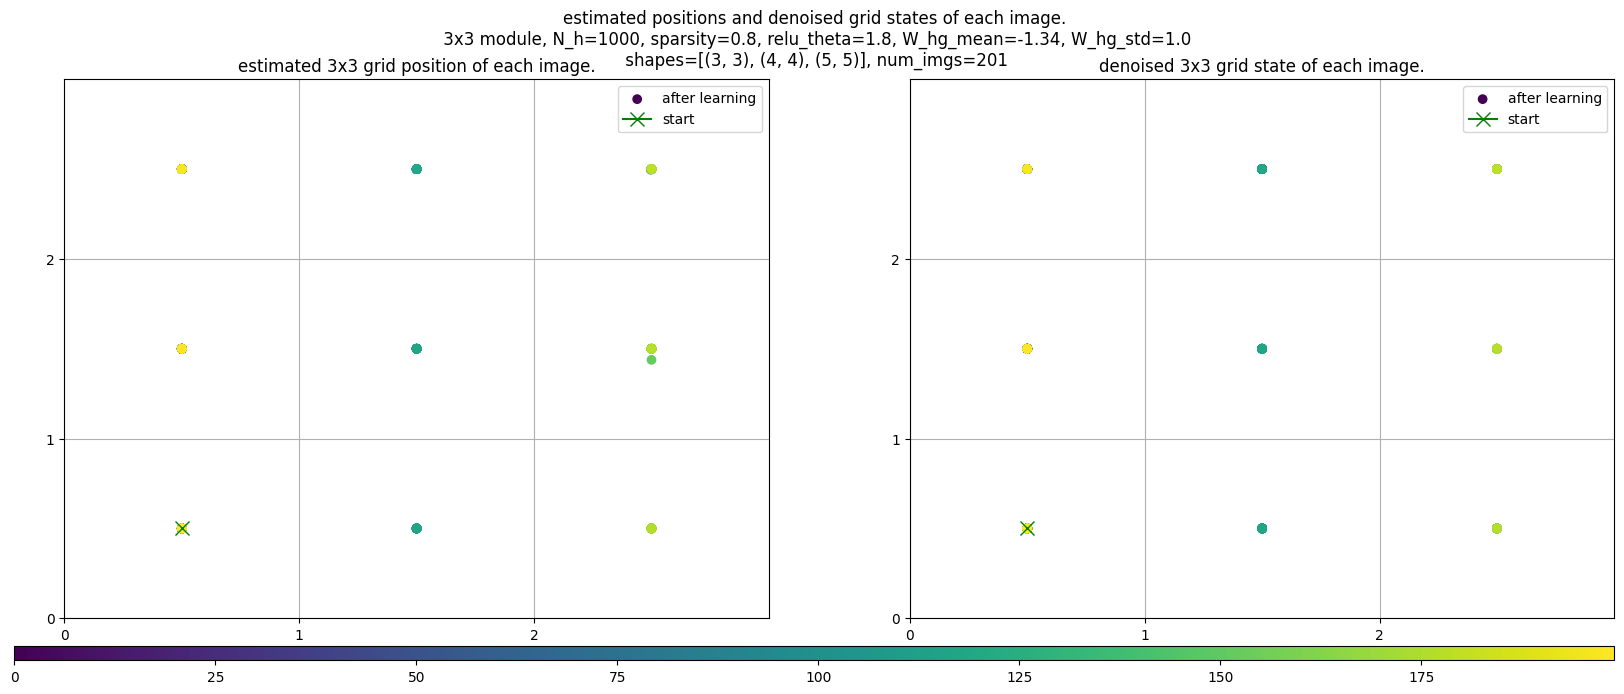

200
200


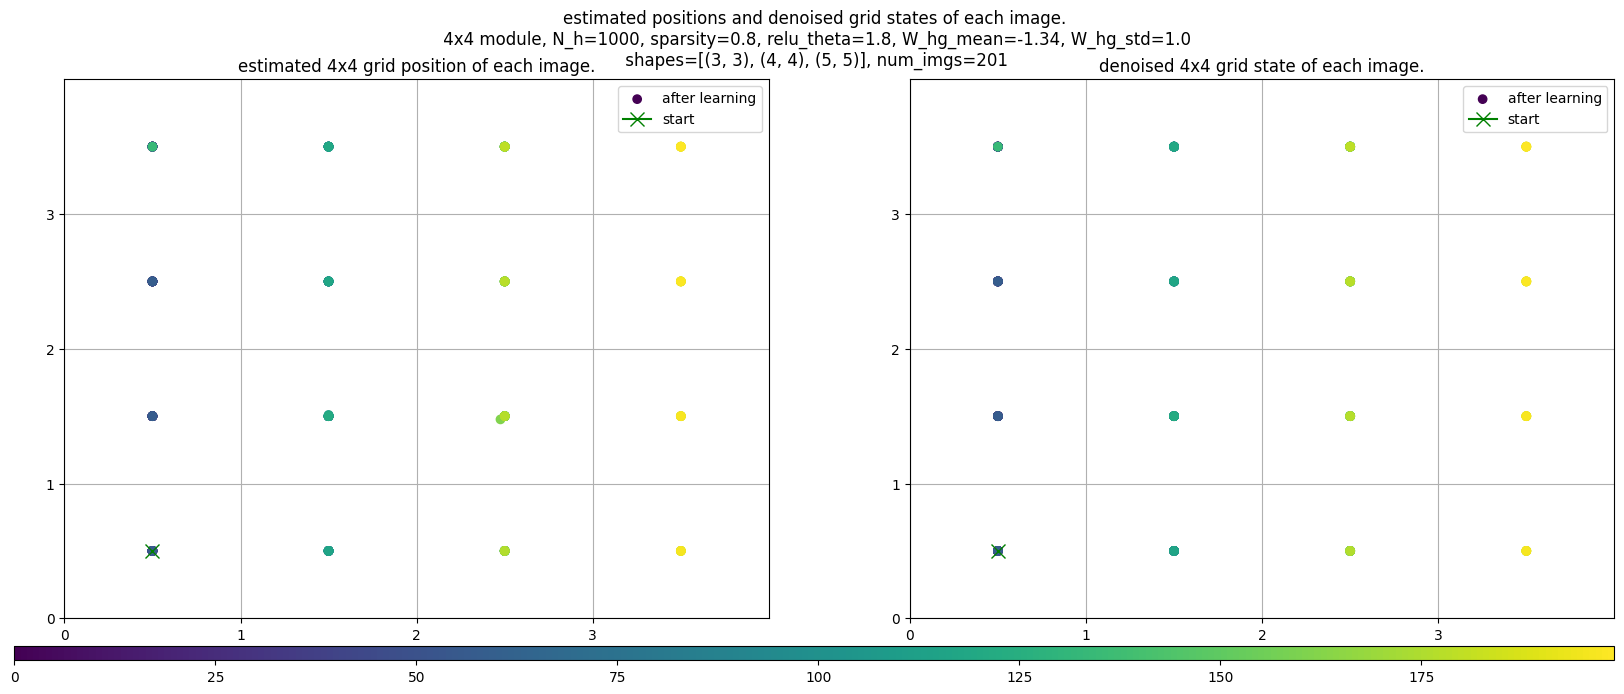

200
200


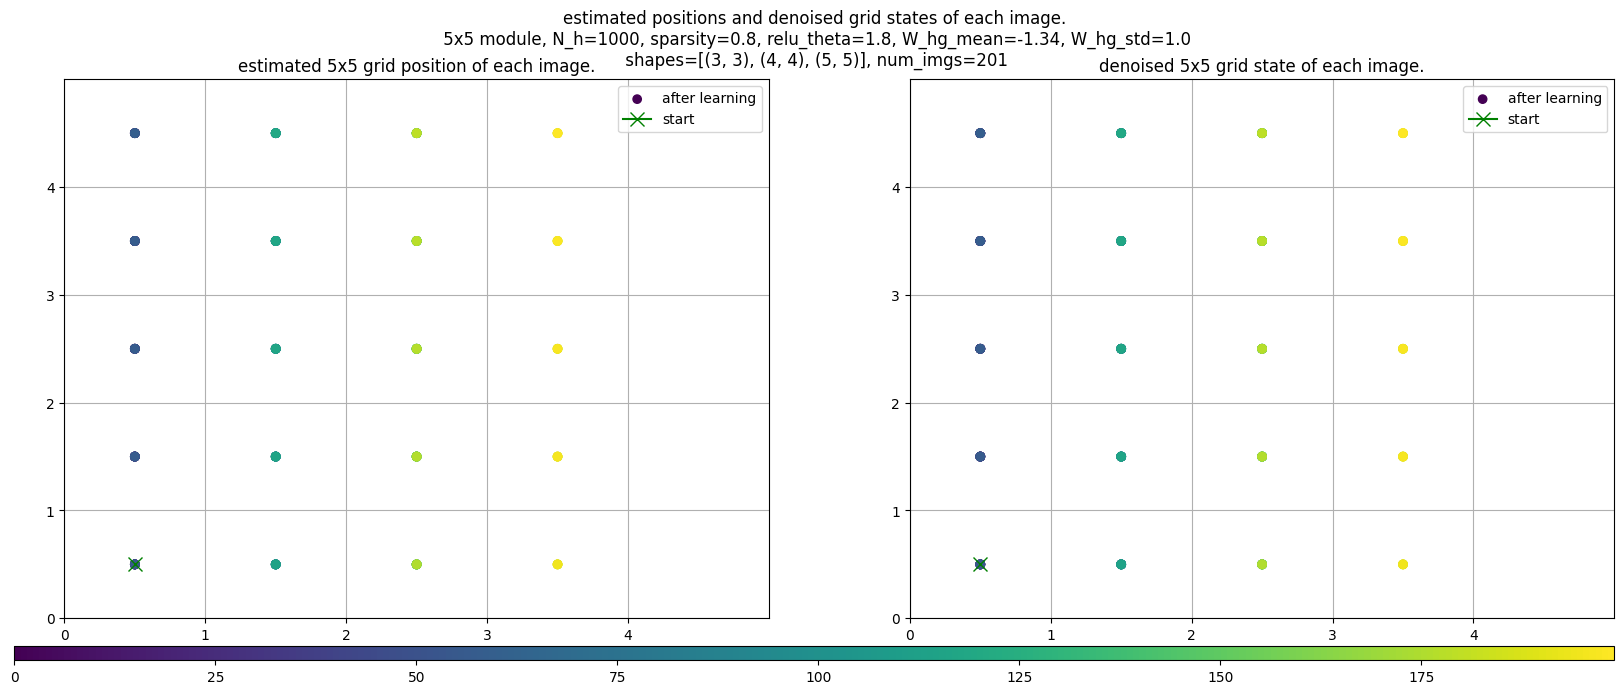

In [ ]:
zero_indices = (dataset.train_labels == 0).nonzero().flatten()

data_by_class = dataset.data[zero_indices][:200].reshape(200, 784)
data_by_class = torch.tensor(data).float().to("cpu")
data_by_class = (data - data.mean(dim=0)) / (data.std(dim=0) + 1e-8)

plt.imshow(data_by_class[0].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class[1].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class.mean(dim=0).reshape(28, 28), cmap="gray")
plt.show()

point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data_by_class:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )